Phase 1: Data Collection and Exploration for Equity Factor Model

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import time
import os
import requests
import io
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

class EquityDataCollector:
    """
    Collects equity price data for multiple stocks and indexes
    """
    def __init__(self, cache_dir='data'):
        """
        Initialize the data collector
        
        Parameters:
        -----------
        cache_dir : str
            Directory to store cached data
        """
        self.cache_dir = cache_dir
        
        # Create cache directory if it doesn't exist
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
            
        # Create subdirectories
        for subdir in ['prices', 'options', 'factors', 'preprocessed']:
            subdir_path = os.path.join(cache_dir, subdir)
            if not os.path.exists(subdir_path):
                os.makedirs(subdir_path)
        
        # Initialize S&P 500 constituents
        self.sp500 = None
        
    def get_sp500_constituents(self, refresh=False):
        """
        Get current S&P 500 constituents with sector information
        
        Parameters:
        -----------
        refresh : bool
            Whether to refresh the constituents list from the web
            
        Returns:
        --------
        pandas.DataFrame: S&P 500 constituents with sector information
        """
        cache_file = os.path.join(self.cache_dir, 'sp500_constituents.csv')
        
        if os.path.exists(cache_file) and not refresh:
            # Load from cache
            print(f"Loading S&P 500 constituents from cache: {cache_file}")
            sp500 = pd.read_csv(cache_file)
        else:
            try:
                # Scrape Wikipedia for S&P 500 constituents
                print("Fetching S&P 500 constituents from Wikipedia...")
                url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
                tables = pd.read_html(url)
                sp500 = tables[0]
                
                # Rename columns
                sp500 = sp500.rename(columns={
                    'Symbol': 'ticker',
                    'Security': 'company_name',
                    'GICS Sector': 'sector',
                    'GICS Sub-Industry': 'sub_industry',
                    'CIK': 'cik',
                    'Headquarters Location': 'location',
                    'Date added': 'date_added',
                    'Founded': 'founded'
                })
                
                # Clean tickers (some may have dots or special characters)
                sp500['ticker'] = sp500['ticker'].str.replace('.', '-')
                
                # Save to cache
                sp500.to_csv(cache_file, index=False)
                print(f"Saved S&P 500 constituents to: {cache_file}")
                
            except Exception as e:
                print(f"Error fetching S&P 500 constituents: {e}")
                # Use a fallback if available
                if os.path.exists(cache_file):
                    print(f"Using cached S&P 500 constituents as fallback")
                    sp500 = pd.read_csv(cache_file)
                else:
                    # Create a simple fallback with major stocks
                    print("Creating fallback S&P 500 data with major stocks")
                    sp500 = pd.DataFrame({
                        'ticker': ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'JPM', 'V', 'PG',
                                 'UNH', 'HD', 'BAC', 'XOM', 'PFE', 'CSCO', 'CVX', 'ADBE', 'CRM', 'NFLX'],
                        'company_name': ['Apple Inc.', 'Microsoft Corp.', 'Amazon.com Inc.', 'Alphabet Inc.',
                                       'Meta Platforms Inc.', 'Tesla Inc.', 'NVIDIA Corp.', 'JPMorgan Chase & Co.',
                                       'Visa Inc.', 'Procter & Gamble Co.', 'UnitedHealth Group Inc.',
                                       'Home Depot Inc.', 'Bank of America Corp.', 'Exxon Mobil Corp.',
                                       'Pfizer Inc.', 'Cisco Systems Inc.', 'Chevron Corp.',
                                       'Adobe Inc.', 'Salesforce Inc.', 'Netflix Inc.'],
                        'sector': ['Information Technology', 'Information Technology', 'Consumer Discretionary',
                                 'Communication Services', 'Communication Services', 'Consumer Discretionary',
                                 'Information Technology', 'Financials', 'Financials', 'Consumer Staples',
                                 'Health Care', 'Consumer Discretionary', 'Financials', 'Energy',
                                 'Health Care', 'Information Technology', 'Energy', 'Information Technology',
                                 'Information Technology', 'Communication Services']
                    })
                    sp500.to_csv(cache_file, index=False)
        
        self.sp500 = sp500
        return sp500
    
    def get_sample_stocks(self, n_stocks=50, min_per_sector=3, seed=42):
        """
        Get a balanced sample of stocks from the S&P 500
        
        Parameters:
        -----------
        n_stocks : int
            Number of stocks to sample
        min_per_sector : int
            Minimum number of stocks per sector
        seed : int
            Random seed for reproducibility
            
        Returns:
        --------
        pandas.DataFrame: Sampled stocks with sector information
        """
        if self.sp500 is None:
            self.get_sp500_constituents()
        
        np.random.seed(seed)
        
        # Ensure we have at least min_per_sector stocks from each sector
        sectors = self.sp500['sector'].unique()
        
        # Initialize sampled stocks
        sampled_stocks = pd.DataFrame()
        
        # First, take min_per_sector stocks from each sector
        for sector in sectors:
            sector_stocks = self.sp500[self.sp500['sector'] == sector]
            
            # If sector has fewer stocks than min_per_sector, take all of them
            if len(sector_stocks) <= min_per_sector:
                sampled_stocks = pd.concat([sampled_stocks, sector_stocks])
            else:
                # Sample min_per_sector stocks from this sector
                sector_sample = sector_stocks.sample(min_per_sector)
                sampled_stocks = pd.concat([sampled_stocks, sector_sample])
        
        # If we need more stocks, sample randomly from the remaining
        if len(sampled_stocks) < n_stocks:
            remaining = self.sp500[~self.sp500['ticker'].isin(sampled_stocks['ticker'])]
            additional_sample = remaining.sample(min(len(remaining), n_stocks - len(sampled_stocks)))
            sampled_stocks = pd.concat([sampled_stocks, additional_sample])
        
        # If we have more stocks than requested, trim randomly
        if len(sampled_stocks) > n_stocks:
            sampled_stocks = sampled_stocks.sample(n_stocks)
        
        # Reset index
        sampled_stocks = sampled_stocks.reset_index(drop=True)
        
        print(f"Selected {len(sampled_stocks)} stocks from {len(sectors)} sectors")
        
        # Print sector distribution
        sector_counts = sampled_stocks['sector'].value_counts()
        print("\nSector distribution:")
        for sector, count in sector_counts.items():
            print(f"  {sector}: {count} stocks")
        
        return sampled_stocks
    
    def fetch_historical_prices(self, tickers, start_date='2020-01-01', end_date=None, 
                              interval='1d', adjust=True, refresh=False):
        """
        Fetch historical price data for multiple tickers
        
        Parameters:
        -----------
        tickers : list
            List of ticker symbols
        start_date : str
            Start date for data (YYYY-MM-DD)
        end_date : str, optional
            End date for data (YYYY-MM-DD), defaults to today
        interval : str
            Data interval ('1d', '1wk', '1mo')
        adjust : bool
            Whether to use adjusted prices
        refresh : bool
            Whether to refresh data from the source
            
        Returns:
        --------
        dict: Dictionary of pandas.DataFrame price data by ticker
        """
        # Set default end date to today if not provided
        if end_date is None:
            end_date = datetime.datetime.now().strftime('%Y-%m-%d')
        
        # Create filename based on parameters
        filename = f"prices_{start_date}_to_{end_date}_{interval}.pkl"
        cache_file = os.path.join(self.cache_dir, 'prices', filename)
        
        # Check if data is cached and we don't want to refresh
        if os.path.exists(cache_file) and not refresh:
            print(f"Loading cached price data from: {cache_file}")
            try:
                price_data = pd.read_pickle(cache_file)
                
                # Check if we have all the tickers
                missing_tickers = [ticker for ticker in tickers if ticker not in price_data]
                
                if not missing_tickers:
                    return price_data
                else:
                    print(f"Missing {len(missing_tickers)} tickers in cache. Fetching missing data...")
                    tickers = missing_tickers
            except Exception as e:
                print(f"Error loading cached price data: {e}")
                price_data = {}
        else:
            price_data = {}
        
        # Fetch data for all tickers
        print(f"Fetching historical price data for {len(tickers)} tickers...")
        
        # Use tqdm for progress bar
        for ticker in tqdm(tickers):
            try:
                # Fetch data with retry logic
                attempts = 0
                max_attempts = 3
                success = False
                
                while not success and attempts < max_attempts:
                    try:
                        stock = yf.Ticker(ticker)
                        hist = stock.history(start=start_date, end=end_date, interval=interval, auto_adjust=adjust)
                        
                        if not hist.empty:
                            # Store in dictionary
                            price_data[ticker] = hist
                            success = True
                        else:
                            print(f"No data returned for {ticker}, retrying ({attempts+1}/{max_attempts})...")
                            attempts += 1
                            time.sleep(1)  # Wait before retrying
                    except Exception as e:
                        print(f"Error fetching data for {ticker}: {e}")
                        attempts += 1
                        time.sleep(2)  # Longer wait on exception
                
                if not success:
                    print(f"Failed to fetch data for {ticker} after {max_attempts} attempts")
            
            except Exception as e:
                print(f"Unexpected error with {ticker}: {e}")
        
        # Save to cache
        print(f"Saving price data to cache: {cache_file}")
        pd.to_pickle(price_data, cache_file)
        
        return price_data
    
    def fetch_factor_data(self, start_date='2020-01-01', end_date=None, refresh=False):
        """
        Fetch common risk factor data (Fama-French, momentum, volatility)
        
        Parameters:
        -----------
        start_date : str
            Start date for data (YYYY-MM-DD)
        end_date : str, optional
            End date for data (YYYY-MM-DD), defaults to today
        refresh : bool
            Whether to refresh data from the source
            
        Returns:
        --------
        pandas.DataFrame: Factor data
        """
        # Set default end date to today if not provided
        if end_date is None:
            end_date = datetime.datetime.now().strftime('%Y-%m-%d')
        
        # Create filename based on parameters
        filename = f"factors_{start_date}_to_{end_date}.csv"
        cache_file = os.path.join(self.cache_dir, 'factors', filename)
        
        # Check if data is cached and we don't want to refresh
        if os.path.exists(cache_file) and not refresh:
            print(f"Loading cached factor data from: {cache_file}")
            try:
                return pd.read_csv(cache_file, index_col=0, parse_dates=True)
            except Exception as e:
                print(f"Error loading cached factor data: {e}")
                # Continue to fetch new data
        
        # Create a DataFrame with dates as index
        start_dt = pd.to_datetime(start_date)
        end_dt = pd.to_datetime(end_date)
        
        # Create date range
        date_range = pd.date_range(start=start_dt, end=end_dt, freq='B')  # Business days
        factor_data = pd.DataFrame(index=date_range)
        
        # First, try to get Fama-French 5 factors
        try:
            print("Fetching Fama-French factor data...")
            
            # Define URL for Fama-French data
            ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
            
            # Create a specific fallback function for Fama-French data
            def get_fama_french_data():
                # Direct download and read
                try:
                    raw_data = pd.read_csv(ff_url, skiprows=3)
                    
                    # Find where the data starts (after header rows)
                    for i, row in raw_data.iterrows():
                        if isinstance(row.iloc[0], str) and row.iloc[0].isdigit():
                            data_start = i
                            break
                    else:
                        data_start = 0
                    
                    # Extract actual data
                    ff_data = raw_data.iloc[data_start:]
                    
                    # Convert first column to date if needed
                    if ff_data.columns[0] != 'date':
                        ff_data = ff_data.rename(columns={ff_data.columns[0]: 'date'})
                    
                    # Ensure date is in correct format
                    ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m%d', errors='coerce')
                    
                    # Remove rows with invalid dates
                    ff_data = ff_data.dropna(subset=['date'])
                    
                    # Set date as index
                    ff_data = ff_data.set_index('date')
                    
                    # Convert numeric columns to float
                    for col in ff_data.columns:
                        ff_data[col] = pd.to_numeric(ff_data[col], errors='coerce')
                    
                    # Convert from percent to decimal
                    for col in ff_data.columns:
                        if ff_data[col].dtype == 'float64':
                            ff_data[col] = ff_data[col] / 100.0
                    
                    return ff_data
                
                except Exception as e:
                    print(f"Error in Fama-French data extraction: {e}")
                    return None
            
            # Try to get Fama-French data
            ff_factors = get_fama_french_data()
            
            # If successful, add to factor_data
            if ff_factors is not None and not ff_factors.empty:
                # Filter for date range
                ff_factors = ff_factors[(ff_factors.index >= start_dt) & (ff_factors.index <= end_dt)]
                
                # Add to factor_data
                for col in ff_factors.columns:
                    if col in ['Mkt-RF', 'Mkt_RF', 'Mkt.RF', 'mkt_rf', 'Mkt RF']:
                        factor_data['mkt_rf'] = ff_factors[col]
                    elif col.lower() in ['smb']:
                        factor_data['smb'] = ff_factors[col]
                    elif col.lower() in ['hml']:
                        factor_data['hml'] = ff_factors[col]
                    elif col.lower() in ['rmw']:
                        factor_data['rmw'] = ff_factors[col]
                    elif col.lower() in ['cma']:
                        factor_data['cma'] = ff_factors[col]
                    elif col.lower() in ['rf']:
                        factor_data['rf'] = ff_factors[col]
                
                print("Successfully added Fama-French factors")
            else:
                print("Could not retrieve Fama-French factors, using simulated data")
                
                # Create simulated Fama-French factors
                np.random.seed(42)  # For reproducibility
                
                # Generate random values with realistic parameters
                factor_data['mkt_rf'] = np.random.normal(0.0005, 0.01, len(date_range))  # Market minus risk-free
                factor_data['smb'] = np.random.normal(0.0002, 0.005, len(date_range))    # Small minus big
                factor_data['hml'] = np.random.normal(0.0001, 0.006, len(date_range))    # High minus low
                factor_data['rmw'] = np.random.normal(0.0001, 0.004, len(date_range))    # Robust minus weak
                factor_data['cma'] = np.random.normal(0.0001, 0.004, len(date_range))    # Conservative minus aggressive
                factor_data['rf'] = np.random.normal(0.0001, 0.0001, len(date_range))    # Risk-free rate
                
                print("Using simulated Fama-French factors")
        
        except Exception as e:
            print(f"Error fetching Fama-French factor data: {e}")
            
            # Create simulated factors if not already present
            if 'mkt_rf' not in factor_data.columns:
                np.random.seed(42)  # For reproducibility
                factor_data['mkt_rf'] = np.random.normal(0.0005, 0.01, len(date_range))  # Market minus risk-free
                factor_data['smb'] = np.random.normal(0.0002, 0.005, len(date_range))    # Small minus big
                factor_data['hml'] = np.random.normal(0.0001, 0.006, len(date_range))    # High minus low
                factor_data['rmw'] = np.random.normal(0.0001, 0.004, len(date_range))    # Robust minus weak
                factor_data['cma'] = np.random.normal(0.0001, 0.004, len(date_range))    # Conservative minus aggressive
                factor_data['rf'] = np.random.normal(0.0001, 0.0001, len(date_range))    # Risk-free rate
                
                print("Using simulated Fama-French factors")
        
        # Now get market data for momentum and volatility
        try:
            print("Fetching market data for momentum and volatility factors...")
            
            # Use SPY as market proxy
            spy = yf.download('SPY', start=start_date, end=end_date, progress=False)
            
            if not spy.empty and 'Close' in spy.columns:
                # Calculate returns
                spy['return'] = spy['Close'].pct_change()
                
                # Calculate momentum (12-month rolling return)
                spy['momentum'] = spy['Close'].pct_change(252).fillna(0)
                
                # Calculate volatility (21-day rolling std dev of returns)
                spy['volatility'] = spy['return'].rolling(21).std().fillna(spy['return'].std())
                
                # Create new DataFrame with momentum and volatility
                spy_factors = pd.DataFrame({'momentum': spy['momentum'], 'volatility': spy['volatility']})
                
                # Align indices between factor_data and spy_factors using merge
                # Convert spy index to DataFrame first
                spy_df = spy_factors.reset_index()
                if 'index' in spy_df.columns:
                    spy_df.rename(columns={'index': 'date'}, inplace=True)
                elif 'Date' in spy_df.columns:
                    spy_df.rename(columns={'Date': 'date'}, inplace=True)
                
                # Convert factor_data index to DataFrame
                factor_df = factor_data.reset_index()
                if 'index' in factor_df.columns:
                    factor_df.rename(columns={'index': 'date'}, inplace=True)
                
                # Merge on date
                merged_df = pd.merge(factor_df, spy_df, on='date', how='left')
                
                # Set date as index again
                merged_df.set_index('date', inplace=True)
                
                # Update factor_data with the merged values
                factor_data = merged_df
                
                print("Successfully added momentum and volatility factors")
            else:
                print("Could not retrieve market data, using simulated momentum and volatility")
                
                # Create simulated momentum and volatility
                np.random.seed(43)  # Different seed from Fama-French
                factor_data['momentum'] = np.random.normal(0.001, 0.02, len(date_range))
                factor_data['volatility'] = np.abs(np.random.normal(0.01, 0.005, len(date_range)))
                
                print("Using simulated momentum and volatility factors")
            
        except Exception as e:
            print(f"Error fetching market data: {e}")
            
            # Create simulated momentum and volatility if not already present
            if 'momentum' not in factor_data.columns:
                np.random.seed(43)  # Different seed from Fama-French
                factor_data['momentum'] = np.random.normal(0.001, 0.02, len(date_range))
                factor_data['volatility'] = np.abs(np.random.normal(0.01, 0.005, len(date_range)))
                
                print("Using simulated momentum and volatility factors")
        
        # Fill missing values with forward and backward fill
        factor_data = factor_data.fillna(method='ffill').fillna(method='bfill')
        
        # Save to cache
        print(f"Saving factor data to cache: {cache_file}")
        factor_data.to_csv(cache_file)
        
        return factor_data
    
    def get_options_data(self, tickers, dte_min=10, dte_max=120, refresh=False):
        """
        Fetch options data for a list of tickers using an OptionsDataFetcher
        
        Parameters:
        -----------
        tickers : list
            List of ticker symbols
        dte_min : int
            Minimum days to expiration
        dte_max : int
            Maximum days to expiration
        refresh : bool
            Whether to refresh data from the source
            
        Returns:
        --------
        dict: Dictionary of options data by ticker
        """
        # Create filename based on parameters
        today = datetime.datetime.now().strftime('%Y%m%d')
        filename = f"options_data_{today}.pkl"
        cache_file = os.path.join(self.cache_dir, 'options', filename)
        
        # Check if data is cached and we don't want to refresh
        if os.path.exists(cache_file) and not refresh:
            print(f"Loading cached options data from: {cache_file}")
            try:
                options_data = pd.read_pickle(cache_file)
                
                # Check if we have all the tickers
                missing_tickers = [ticker for ticker in tickers if ticker not in options_data]
                
                if not missing_tickers:
                    return options_data
                else:
                    print(f"Missing {len(missing_tickers)} tickers in cache. Fetching missing data...")
                    tickers = missing_tickers
            except Exception as e:
                print(f"Error loading cached options data: {e}")
                options_data = {}
        else:
            options_data = {}
        
        # Import your OptionsDataFetcher class
        try:
            # Try to import your existing module
            from options_module import OptionsDataFetcher
            options_fetcher = OptionsDataFetcher()
            print("Using your custom OptionsDataFetcher")
        except ImportError:
            # Create a basic mock OptionsDataFetcher if your module isn't available
            print("Custom OptionsDataFetcher not found, using mock implementation")
            options_fetcher = MockOptionsDataFetcher()
        
        # Fetch options data for all tickers
        print(f"Fetching options data for {len(tickers)} tickers...")
        
        for ticker in tqdm(tickers):
            try:
                # Fetch options data
                option_chain = options_fetcher.get_option_chain(ticker, dte_min=dte_min, dte_max=dte_max)
                
                if option_chain is not None:
                    options_data[ticker] = option_chain
                    
                    # Optional: Save individual ticker data as CSV
                    calls_file = os.path.join(self.cache_dir, 'options', f"{ticker}_calls.csv")
                    puts_file = os.path.join(self.cache_dir, 'options', f"{ticker}_puts.csv")
                    
                    option_chain['calls'].to_csv(calls_file, index=False)
                    option_chain['puts'].to_csv(puts_file, index=False)
                    
                    print(f"Saved options data for {ticker}")
                else:
                    print(f"No options data available for {ticker}")
                
                # Be nice to the API
                time.sleep(1)
                
            except Exception as e:
                print(f"Error fetching options data for {ticker}: {e}")
        
        # Save to cache
        print(f"Saving options data to cache: {cache_file}")
        pd.to_pickle(options_data, cache_file)
        
        return options_data


class MockOptionsDataFetcher:
    """Mock implementation of OptionsDataFetcher for testing"""
    
    def __init__(self):
        self.current_date = datetime.datetime.now().date()
    
    def get_option_chain(self, ticker, dte_min=10, dte_max=120):
        """
        Generate mock option chain data for testing
        
        Parameters:
        -----------
        ticker : str
            Ticker symbol
        dte_min : int
            Minimum days to expiration
        dte_max : int
            Maximum days to expiration
            
        Returns:
        --------
        dict: Mock option chain data with calls and puts
        """
        print(f"Generating mock options data for {ticker}")
        
        # Create fake spot price - different for each ticker for variety
        # Hash the ticker to get a consistent but varied price
        ticker_hash = sum(ord(c) for c in ticker)
        base_price = 100 + (ticker_hash % 400)  # Price between 100 and 500
        spot_price = base_price + (np.random.random() * 10 - 5)  # Add some randomness
        
        # Generate expiration dates
        current_date = self.current_date
        expiration_dates = []
        
        # Weekly expirations
        for week in range(1, 8):
            dte = week * 7
            if dte_min <= dte <= dte_max:
                exp_date = (current_date + datetime.timedelta(days=dte)).strftime('%Y-%m-%d')
                expiration_dates.append(exp_date)
        
        # Monthly expirations
        for month in range(1, 6):
            dte = month * 30
            if dte_min <= dte <= dte_max:
                exp_date = (current_date + datetime.timedelta(days=dte)).strftime('%Y-%m-%d')
                expiration_dates.append(exp_date)
        
        # Generate strike prices (centered around spot price)
        strike_range = 0.3  # Strike prices within ±30% of spot
        strikes = np.linspace(
            spot_price * (1 - strike_range),
            spot_price * (1 + strike_range),
            15
        )
        
        # Generate option chains
        calls_data = []
        puts_data = []
        
        for exp_date in expiration_dates:
            # Convert to datetime for calculations
            exp_datetime = datetime.datetime.strptime(exp_date, '%Y-%m-%d').date()
            dte = (exp_datetime - current_date).days
            tte = dte / 365.0  # Time to expiration in years
            
            for strike in strikes:
                # Calculate moneyness
                moneyness = strike / spot_price
                
                # Base IV with smile effect
                base_iv = 0.2 + 0.1 * (moneyness - 1) ** 2
                
                # Add term structure effect (higher IV for longer dates)
                iv_term = 0.05 * np.sqrt(tte)
                
                # Generate call option
                call = {
                    'contractSymbol': f"{ticker}{exp_date.replace('-', '')}C{int(strike * 100):08d}",
                    'strike': strike,
                    'lastPrice': max(0.01, spot_price - strike) + np.random.random() * 2,
                    'bid': max(0.01, spot_price - strike) * 0.95,
                    'ask': max(0.01, spot_price - strike) * 1.05 + 0.1,
                    'impliedVolatility': base_iv + iv_term,
                    'volume': int(np.random.exponential(100) * (1.5 - abs(moneyness - 1))),
                    'openInterest': int(np.random.exponential(500) * (1.5 - abs(moneyness - 1))),
                    'inTheMoney': strike < spot_price,
                    'expirationDate': exp_date,
                    'dte': dte,
                    'tte': tte,
                    'moneyness': moneyness
                }
                
                # Generate put option
                put = {
                    'contractSymbol': f"{ticker}{exp_date.replace('-', '')}P{int(strike * 100):08d}",
                    'strike': strike,
                    'lastPrice': max(0.01, strike - spot_price) + np.random.random() * 2,
                    'bid': max(0.01, strike - spot_price) * 0.95,
                    'ask': max(0.01, strike - spot_price) * 1.05 + 0.1,
                    'impliedVolatility': base_iv + iv_term + 0.02,  # Puts typically have higher IV
                    'volume': int(np.random.exponential(100) * (1.5 - abs(moneyness - 1))),
                    'openInterest': int(np.random.exponential(500) * (1.5 - abs(moneyness - 1))),
                    'inTheMoney': strike > spot_price,
                    'expirationDate': exp_date,
                    'dte': dte,
                    'tte': tte,
                    'moneyness': moneyness
                }
                
                # Adjust prices for realistic values
                call['lastPrice'] = max(0.01, call['lastPrice'])
                put['lastPrice'] = max(0.01, put['lastPrice'])
                call['bid'] = max(0.01, call['bid'])
                put['bid'] = max(0.01, put['bid'])
                call['ask'] = max(call['bid'] + 0.01, call['ask'])
                put['ask'] = max(put['bid'] + 0.01, put['ask'])
                
                # Add a usePrice column (mid price)
                call['usePrice'] = (call['bid'] + call['ask']) / 2
                put['usePrice'] = (put['bid'] + put['ask']) / 2
                
                calls_data.append(call)
                puts_data.append(put)
        
        # Convert to DataFrames
        calls_df = pd.DataFrame(calls_data)
        puts_df = pd.DataFrame(puts_data)
        
        # Return options data
        return {
            'ticker': ticker,
            'spot_price': spot_price,
            'calls': calls_df,
            'puts': puts_df,
            'quote_date': current_date,
            'risk_free_rate': 0.05  # 5% risk-free rate
        }


class DataPreprocessor:
    """
    Preprocesses and cleans financial data for modeling
    """
    def __init__(self, cache_dir='data'):
        """
        Initialize the data preprocessor
        
        Parameters:
        -----------
        cache_dir : str
            Directory for cached data
        """
        self.cache_dir = cache_dir
        
    def calculate_returns(self, price_data, period='daily'):
        """
        Calculate returns from price data
        
        Parameters:
        -----------
        price_data : dict
            Dictionary of price DataFrames by ticker
        period : str
            'daily', 'weekly', or 'monthly'
            
        Returns:
        --------
        dict: Dictionary of return DataFrames by ticker
        """
        returns_data = {}
        
        for ticker, prices in price_data.items():
            try:
                # Make a copy of the price data
                df = prices.copy()
                
                # Calculate returns based on specified period
                if 'Close' in df.columns:
                    if period == 'daily':
                        df['return'] = df['Close'].pct_change()
                    elif period == 'weekly':
                        df['return'] = df['Close'].pct_change(5)
                    elif period == 'monthly':
                        df['return'] = df['Close'].pct_change(21)
                    else:
                        raise ValueError(f"Invalid period: {period}")
                else:
                    # If no Close column, try Adj Close or use first numeric column
                    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
                    if 'Adj Close' in df.columns:
                        df['return'] = df['Adj Close'].pct_change()
                    elif len(numeric_cols) > 0:
                        df['return'] = df[numeric_cols[0]].pct_change()
                    else:
                        print(f"Could not calculate returns for {ticker}: no suitable price column found")
                        df['return'] = 0  # Default to zero returns
                
                # Store in dictionary
                returns_data[ticker] = df
            except Exception as e:
                print(f"Error calculating returns for {ticker}: {e}")
                # Add placeholder with zero returns
                returns_data[ticker] = prices.copy()
                returns_data[ticker]['return'] = 0
        
        return returns_data
    
    def calculate_stock_factors(self, price_data, market_ticker='SPY'):
        """
        Calculate stock-specific factors
        
        Parameters:
        -----------
        price_data : dict
            Dictionary of price DataFrames by ticker
        market_ticker : str
            Ticker to use as market benchmark
            
        Returns:
        --------
        pandas.DataFrame: Stock factors by ticker and date
        """
        # Get market data if available, otherwise create dummy
        if market_ticker in price_data:
            market_data = price_data[market_ticker].copy()
            
            # Calculate market returns
            if 'Close' in market_data.columns:
                market_data['market_return'] = market_data['Close'].pct_change()
            elif 'Adj Close' in market_data.columns:
                market_data['market_return'] = market_data['Adj Close'].pct_change()
            else:
                # Use first numeric column
                numeric_cols = market_data.select_dtypes(include=['float64', 'int64']).columns
                if len(numeric_cols) > 0:
                    market_data['market_return'] = market_data[numeric_cols[0]].pct_change()
                else:
                    print(f"Could not calculate market returns: no suitable price column found")
                    # Create a synthetic market return
                    market_data['market_return'] = np.random.normal(0.0005, 0.01, len(market_data))
        else:
            print(f"Market ticker {market_ticker} not found in price data. Using synthetic market returns.")
            
            # Create a synthetic market index with dates from the first ticker
            if price_data:
                first_ticker = list(price_data.keys())[0]
                market_data = pd.DataFrame(index=price_data[first_ticker].index)
                market_data['market_return'] = np.random.normal(0.0005, 0.01, len(market_data))
            else:
                print("No price data available. Cannot calculate stock factors.")
                return pd.DataFrame()
        
        # Initialize factors list
        factors = []
        
        # Process each stock
        for ticker, prices in price_data.items():
            if ticker == market_ticker:
                continue
                
            try:
                # Make a copy
                df = prices.copy()
                
                # Calculate daily returns
                if 'Close' in df.columns:
                    df['return'] = df['Close'].pct_change()
                elif 'Adj Close' in df.columns:
                    df['return'] = df['Adj Close'].pct_change()
                else:
                    # Use first numeric column
                    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
                    if len(numeric_cols) > 0:
                        df['return'] = df[numeric_cols[0]].pct_change()
                    else:
                        print(f"Could not calculate returns for {ticker}: no suitable price column found")
                        df['return'] = 0  # Default to zero returns
                
                # Calculate size factor (log of market cap if volume is available)
                if 'Close' in df.columns and 'Volume' in df.columns:
                    df['size'] = np.log(df['Close'] * df['Volume'])
                else:
                    # Use a random size factor if volume not available
                    df['size'] = np.random.normal(10, 2, len(df))
                
                # Calculate value factor (approximate with price ratio)
                if 'Low' in df.columns and 'High' in df.columns:
                    df['value'] = df['Low'] / df['High'].rolling(20).mean()
                else:
                    # Use a random value factor
                    df['value'] = np.random.normal(0.8, 0.1, len(df))
                
                # Calculate momentum (12-month rolling return)
                if 'Close' in df.columns:
                    df['momentum_12m'] = df['Close'].pct_change(252)
                elif 'Adj Close' in df.columns:
                    df['momentum_12m'] = df['Adj Close'].pct_change(252)
                else:
                    # Use cumulative return of daily returns
                    df['momentum_12m'] = df['return'].rolling(252).apply(lambda x: (1 + x).prod() - 1)
                
                # Calculate volatility (1-month rolling volatility)
                df['volatility'] = df['return'].rolling(21).std()
                
                # Calculate beta using a rolling window
                # Align market returns with stock returns
                if 'market_return' in market_data.columns:
                    market_returns = market_data['market_return']
                    aligned_market = market_returns.loc[df.index.intersection(market_returns.index)]
                    
                    # Ensure alignment
                    if not aligned_market.empty and len(aligned_market) > 30:
                        # Calculate betas using 1-year rolling window
                        betas = []
                        for i in range(252, len(df)):
                            if i >= len(aligned_market):
                                continue
                            
                            stock_window = df['return'].iloc[i-252:i]
                            market_window = aligned_market.iloc[i-252:i]
                            
                            # Skip if either window has all NaNs
                            if stock_window.isna().all() or market_window.isna().all():
                                betas.append(np.nan)
                                continue
                            
                            # Calculate covariance
                            cov = np.cov(stock_window.fillna(0), market_window.fillna(0))[0, 1]
                            var = np.var(market_window.fillna(0))
                            
                            # Calculate beta
                            if var != 0:
                                beta = cov / var
                            else:
                                beta = np.nan
                            
                            betas.append(beta)
                        
                        # Pad beginning with NaNs
                        betas = [np.nan] * 252 + betas
                        
                        # Ensure length matches df
                        betas = betas[:len(df)]
                        
                        # Assign to dataframe
                        df['beta'] = betas
                    else:
                        # If not enough data, assign NaNs
                        df['beta'] = np.nan
                else:
                    # If market returns not available, assign NaNs
                    df['beta'] = np.nan
                
                # Fill NaNs
                df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
                
                # Prepare data for the factors DataFrame
                stock_factors = df[['return', 'size', 'value', 'momentum_12m', 'volatility', 'beta']].copy()
                stock_factors['ticker'] = ticker
                
                # Add to list
                factors.append(stock_factors)
                
            except Exception as e:
                print(f"Error calculating factors for {ticker}: {e}")
                # Skip this ticker
        
        # Combine all factors
        if factors:
            combined_factors = pd.concat(factors)
            
            # Reset index to include date as a column
            combined_factors = combined_factors.reset_index()
            
            # Rename index to date if needed
            if 'index' in combined_factors.columns and 'date' not in combined_factors.columns:
                combined_factors = combined_factors.rename(columns={'index': 'date'})
            
            return combined_factors
        else:
            print("No valid factors calculated.")
            return pd.DataFrame()
    
    def align_data(self, price_returns, factor_data):
        """
        Align price returns with factor data
        
        Parameters:
        -----------
        price_returns : dict
            Dictionary of return DataFrames by ticker
        factor_data : pandas.DataFrame
            Factor data
            
        Returns:
        --------
        pandas.DataFrame: Aligned returns and factors
        """
        # Initialize list to store aligned data
        aligned_data = []
        
        # Process each ticker
        for ticker, returns in price_returns.items():
            try:
                # Make a copy and ensure it has a return column
                df = returns.copy()
                if 'return' not in df.columns:
                    print(f"No return column for {ticker}, skipping")
                    continue
                
                # Keep only the return column and reset index
                df_returns = df[['return']].copy()
                df_returns = df_returns.reset_index()
                df_returns['ticker'] = ticker
                
                # Ensure it has a date column - handle both 'Date' and 'index' cases
                if 'date' not in df_returns.columns:
                    if 'Date' in df_returns.columns:
                        df_returns.rename(columns={'Date': 'date'}, inplace=True)
                    elif 'index' in df_returns.columns:
                        df_returns.rename(columns={'index': 'date'}, inplace=True)
                
                # Add to list
                aligned_data.append(df_returns)
                
            except Exception as e:
                print(f"Error aligning data for {ticker}: {e}")
        
        # Combine all returns if we have any
        if not aligned_data:
            print("No valid return data to align with factors.")
            return pd.DataFrame()
            
        combined_returns = pd.concat(aligned_data)
        
        # Reset factor_data index to create date column
        factor_data_reset = factor_data.reset_index()
        
        # Ensure it has a date column - handle both 'Date' and 'index' cases
        if 'date' not in factor_data_reset.columns:
            if 'Date' in factor_data_reset.columns:
                factor_data_reset.rename(columns={'Date': 'date'}, inplace=True)
            elif 'index' in factor_data_reset.columns:
                factor_data_reset.rename(columns={'index': 'date'}, inplace=True)
        
        # Make sure date columns are datetime
        combined_returns['date'] = pd.to_datetime(combined_returns['date'])
        factor_data_reset['date'] = pd.to_datetime(factor_data_reset['date'])
        
        # Handle timezone differences - normalize datetime to remove timezone information
        combined_returns['date'] = combined_returns['date'].dt.tz_localize(None)
        factor_data_reset['date'] = factor_data_reset['date'].dt.tz_localize(None)
        
        # Perform the merge
        try:
            aligned = pd.merge(combined_returns, factor_data_reset, on='date', how='left')
            
            # Fill missing values
            aligned = aligned.fillna(method='ffill').fillna(method='bfill').fillna(0)
            
            return aligned
            
        except Exception as e:
            print(f"Error merging returns and factors: {e}")
            
            # Create a minimal aligned dataset with returns only
            print("Creating minimal aligned dataset with returns only.")
            aligned_data = pd.DataFrame()
            
            for ticker, returns in price_returns.items():
                # Extract returns and add ticker
                ticker_returns = returns[['return']].copy() if 'return' in returns.columns else pd.DataFrame(index=returns.index)
                ticker_returns['ticker'] = ticker
                
                # Reset index to convert to column
                ticker_returns = ticker_returns.reset_index()
                
                # Ensure it has a date column - handle both 'Date' and 'index' cases
                if 'date' not in ticker_returns.columns:
                    if 'Date' in ticker_returns.columns:
                        ticker_returns.rename(columns={'Date': 'date'}, inplace=True)
                    elif 'index' in ticker_returns.columns:
                        ticker_returns.rename(columns={'index': 'date'}, inplace=True)
                
                # Normalize timezone
                ticker_returns['date'] = pd.to_datetime(ticker_returns['date'])
                if hasattr(ticker_returns['date'].dt, 'tz_localize'):
                    ticker_returns['date'] = ticker_returns['date'].dt.tz_localize(None)
                
                # Add to aligned data
                if aligned_data.empty:
                    aligned_data = ticker_returns
                else:
                    aligned_data = pd.concat([aligned_data, ticker_returns])
            
            # Add placeholder factor columns
            for col in ['mkt_rf', 'smb', 'hml', 'momentum', 'volatility']:
                aligned_data[col] = 0
            
            return aligned_data
    
    def prepare_modeling_dataset(self, price_data, factor_data, stock_factors=None):
        """
        Prepare the final dataset for modeling
        
        Parameters:
        -----------
        price_data : dict
            Dictionary of price DataFrames by ticker
        factor_data : pandas.DataFrame
            Factor data
        stock_factors : pandas.DataFrame, optional
            Stock-specific factors
            
        Returns:
        --------
        pandas.DataFrame: Final modeling dataset
        """
        # Calculate returns
        returns_data = self.calculate_returns(price_data)
        
        # If stock factors not provided, calculate them
        if stock_factors is None:
            try:
                stock_factors = self.calculate_stock_factors(price_data)
            except Exception as e:
                print(f"Error calculating stock factors: {e}")
                stock_factors = None
        
        # Align returns and factor data
        try:
            aligned_data = self.align_data(returns_data, factor_data)
        except Exception as e:
            print(f"Error aligning returns and factors: {e}")
            
            # Create a minimal dataset
            aligned_data = pd.DataFrame()
            
            for ticker, returns in returns_data.items():
                # Extract returns and add ticker
                ticker_returns = returns[['return']].copy() if 'return' in returns.columns else pd.DataFrame(index=returns.index)
                ticker_returns['ticker'] = ticker
                
                # Reset index to convert to column
                ticker_returns = ticker_returns.reset_index()
                
                # Ensure it has a date column - handle both 'Date' and 'index' cases
                if 'date' not in ticker_returns.columns:
                    if 'Date' in ticker_returns.columns:
                        ticker_returns.rename(columns={'Date': 'date'}, inplace=True)
                    elif 'index' in ticker_returns.columns:
                        ticker_returns.rename(columns={'index': 'date'}, inplace=True)
                
                # Normalize timezone
                ticker_returns['date'] = pd.to_datetime(ticker_returns['date'])
                if hasattr(ticker_returns['date'].dt, 'tz_localize'):
                    ticker_returns['date'] = ticker_returns['date'].dt.tz_localize(None)
                
                # Add to aligned data
                if aligned_data.empty:
                    aligned_data = ticker_returns
                else:
                    aligned_data = pd.concat([aligned_data, ticker_returns])
            
            # Add placeholder factor columns
            for col in ['mkt_rf', 'smb', 'hml', 'momentum', 'volatility']:
                aligned_data[col] = 0
        
        # Merge with stock factors if available
        if stock_factors is not None and not stock_factors.empty:
            try:
                # Ensure stock_factors has date and ticker columns
                stock_factors_reset = stock_factors.copy()
                
                # Handle date column in stock_factors
                if 'date' not in stock_factors_reset.columns:
                    if stock_factors_reset.index.name == 'date':
                        stock_factors_reset = stock_factors_reset.reset_index()
                    elif 'Date' in stock_factors_reset.columns:
                        stock_factors_reset.rename(columns={'Date': 'date'}, inplace=True)
                    elif stock_factors_reset.index.name == 'Date':
                        stock_factors_reset = stock_factors_reset.reset_index()
                        stock_factors_reset.rename(columns={'Date': 'date'}, inplace=True)
                
                # Convert date column to datetime if needed and normalize timezone
                if 'date' in stock_factors_reset.columns:
                    stock_factors_reset['date'] = pd.to_datetime(stock_factors_reset['date'])
                    if hasattr(stock_factors_reset['date'].dt, 'tz_localize'):
                        stock_factors_reset['date'] = stock_factors_reset['date'].dt.tz_localize(None)
                
                # Convert ticker column to string if needed
                if 'ticker' in stock_factors_reset.columns:
                    stock_factors_reset['ticker'] = stock_factors_reset['ticker'].astype(str)
                
                # Ensure aligned_data has date and ticker columns
                if 'date' in aligned_data.columns:
                    aligned_data['date'] = pd.to_datetime(aligned_data['date'])
                    if hasattr(aligned_data['date'].dt, 'tz_localize'):
                        aligned_data['date'] = aligned_data['date'].dt.tz_localize(None)
                
                if 'ticker' in aligned_data.columns:
                    aligned_data['ticker'] = aligned_data['ticker'].astype(str)
                
                # Perform the merge
                merge_columns = []
                if 'date' in stock_factors_reset.columns and 'date' in aligned_data.columns:
                    merge_columns.append('date')
                if 'ticker' in stock_factors_reset.columns and 'ticker' in aligned_data.columns:
                    merge_columns.append('ticker')
                
                # Check that we have at least one column to merge on
                if merge_columns:
                    final_data = pd.merge(aligned_data, stock_factors_reset, 
                                          on=merge_columns, how='left', suffixes=('', '_stock'))
                else:
                    print("No common columns found for merging. Using aligned data only.")
                    final_data = aligned_data
            except Exception as e:
                print(f"Error merging with stock factors: {e}")
                final_data = aligned_data
        else:
            final_data = aligned_data
        
        # Handle any remaining missing values
        final_data = final_data.fillna(method='ffill').fillna(method='bfill').fillna(0)
        
        # Optional: Save to file
        output_file = os.path.join(self.cache_dir, 'preprocessed', 'modeling_dataset.csv')
        final_data.to_csv(output_file, index=False)
        print(f"Saved modeling dataset to: {output_file}")
        
        return final_data


def run_data_collection():
    """
    Run the complete data collection process
    """
    # Initialize data collector
    collector = EquityDataCollector(cache_dir='data')
    
    # Step 1: Get S&P 500 constituents and sample stocks
    sp500 = collector.get_sp500_constituents(refresh=True)
    sampled_stocks = collector.get_sample_stocks(n_stocks=80, min_per_sector=5)
    
    # Get list of tickers
    tickers = sampled_stocks['ticker'].tolist()
    
    # For debugging/testing with fewer stocks
    # tickers = tickers[:10]  # Uncomment to use fewer stocks
    
    # Add SPY for market benchmark
    if 'SPY' not in tickers:
        tickers.append('SPY')
    
    # Step 2: Fetch historical price data
    price_data = collector.fetch_historical_prices(
        tickers, 
        start_date='2020-01-01',
        end_date=None,  # Use today as end date
        interval='1d',
        refresh=True
    )
    
    # Step 3: Fetch factor data
    factor_data = collector.fetch_factor_data(
        start_date='2020-01-01',
        end_date=None,  # Use today as end date
        refresh=True
    )
    
    # Step 4: Get options data for a subset of stocks
    # Choose liquid stocks for options analysis
    option_tickers = ['SPY', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'JPM', 'BAC']
    
    # Ensure all option_tickers are in the main ticker list
    option_tickers = [ticker for ticker in option_tickers if ticker in tickers or ticker == 'SPY']
    
    # Fetch options data
    options_data = collector.get_options_data(
        option_tickers,
        dte_min=10,
        dte_max=120,
        refresh=True
    )
    
    # Initialize data preprocessor
    preprocessor = DataPreprocessor(cache_dir='data')
    
    # Step 5: Calculate stock-specific factors
    stock_factors = preprocessor.calculate_stock_factors(price_data)
    
    # Step 6: Prepare modeling dataset
    modeling_data = preprocessor.prepare_modeling_dataset(price_data, factor_data, stock_factors)
    
    # Save the results for easy access
    result = {
        'price_data': price_data,
        'factor_data': factor_data,
        'stock_factors': stock_factors,
        'options_data': options_data,
        'modeling_data': modeling_data
    }
    
    # Save a summary of what data was collected
    summary = {
        'num_stocks': len(price_data),
        'date_range': (modeling_data['date'].min(), modeling_data['date'].max()) if not modeling_data.empty else None,
        'num_options_stocks': len(options_data),
        'option_tickers': list(options_data.keys()) if options_data else []
    }
    
    print("\nData Collection Summary:")
    print(f"Collected price data for {summary['num_stocks']} stocks")
    if summary['date_range']:
        print(f"Date range: {summary['date_range'][0]} to {summary['date_range'][1]}")
    print(f"Collected options data for {summary['num_options_stocks']} stocks")
    print(f"Options tickers: {', '.join(summary['option_tickers'])}")
    
    return result


# Exploratory data analysis function
def explore_data(data):
    """
    Perform basic exploratory data analysis
    
    Parameters:
    -----------
    data : dict
        Dictionary containing the collected data
    """
    # Create plots directory if it doesn't exist
    plots_dir = 'data/plots'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # 1. Analyze price data
    price_data = data['price_data']
    
    if price_data:
        print("\n=== Price Data Analysis ===")
        
        # Select a few tickers for visualization
        sample_tickers = list(price_data.keys())[:5]
        
        for ticker in sample_tickers:
            prices = price_data[ticker]
            
            # Plot price chart
            plt.figure(figsize=(10, 6))
            if 'Close' in prices.columns:
                plt.plot(prices.index, prices['Close'])
                plt.title(f"{ticker} Stock Price")
                plt.xlabel("Date")
                plt.ylabel("Price ($)")
                plt.grid(True, alpha=0.3)
                plt.savefig(f"{plots_dir}/{ticker}_price.png")
                plt.close()
                
                print(f"Created price chart for {ticker}")
    
    # 2. Analyze factor data
    factor_data = data['factor_data']
    
    if not factor_data.empty:
        print("\n=== Factor Data Analysis ===")
        
        # Plot factor returns
        plt.figure(figsize=(12, 8))
        
        factor_cols = ['mkt_rf', 'smb', 'hml', 'momentum', 'volatility']
        factor_cols = [col for col in factor_cols if col in factor_data.columns]
        
        if factor_cols:
            for col in factor_cols:
                cumulative_return = (1 + factor_data[col]).cumprod() - 1
                plt.plot(factor_data.index, cumulative_return, label=col)
            
            plt.title("Cumulative Factor Returns")
            plt.xlabel("Date")
            plt.ylabel("Cumulative Return")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(f"{plots_dir}/factor_returns.png")
            plt.close()
            
            print("Created factor returns chart")
    
    # 3. Analyze options data
    options_data = data['options_data']
    
    if options_data:
        print("\n=== Options Data Analysis ===")
        
        # Select one ticker for visualization
        if 'SPY' in options_data:
            sample_ticker = 'SPY'
        else:
            sample_ticker = list(options_data.keys())[0]
        
        option_data = options_data[sample_ticker]
        
        # Extract calls and puts
        calls = option_data['calls']
        puts = option_data['puts']
        
        # Print basic stats
        print(f"{sample_ticker} options data:")
        print(f"  Spot price: ${option_data['spot_price']:.2f}")
        print(f"  Call options: {len(calls)}")
        print(f"  Put options: {len(puts)}")
        
        # Plot implied volatility smile for one expiration
        if 'expirationDate' in calls.columns and 'moneyness' in calls.columns and 'impliedVolatility' in calls.columns:
            expirations = sorted(calls['expirationDate'].unique())
            
            if expirations:
                # Get nearest expiration
                nearest_exp = expirations[0]
                
                # Filter calls and puts for this expiration
                exp_calls = calls[calls['expirationDate'] == nearest_exp]
                exp_puts = puts[puts['expirationDate'] == nearest_exp]
                
                # Plot IV smile
                plt.figure(figsize=(10, 6))
                
                if not exp_calls.empty:
                    plt.scatter(exp_calls['moneyness'], exp_calls['impliedVolatility'], 
                              label='Calls', alpha=0.7, color='blue')
                
                if not exp_puts.empty:
                    plt.scatter(exp_puts['moneyness'], exp_puts['impliedVolatility'], 
                              label='Puts', alpha=0.7, color='red')
                
                plt.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
                
                plt.title(f"{sample_ticker} Implied Volatility Smile - {nearest_exp}")
                plt.xlabel("Moneyness (Strike/Spot)")
                plt.ylabel("Implied Volatility")
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.savefig(f"{plots_dir}/{sample_ticker}_iv_smile.png")
                plt.close()
                
                print(f"Created IV smile chart for {sample_ticker}")
    
    # 4. Analyze modeling dataset
    modeling_data = data['modeling_data']
    
    if not modeling_data.empty:
        print("\n=== Modeling Data Analysis ===")
        
        # Print basic stats
        print(f"Modeling dataset shape: {modeling_data.shape}")
        print(f"Number of tickers: {modeling_data['ticker'].nunique()}")
        
        # Correlation of factors and returns
        numeric_cols = ['return', 'mkt_rf', 'smb', 'hml', 'momentum', 'volatility']
        numeric_cols = [col for col in numeric_cols if col in modeling_data.columns]
        
        if numeric_cols:
            corr = modeling_data[numeric_cols].corr()
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
            plt.title("Factor Correlation Matrix")
            plt.tight_layout()
            plt.savefig(f"{plots_dir}/factor_correlation.png")
            plt.close()
            
            print("Created factor correlation matrix")
    
    print("\nExploratory data analysis complete. Charts saved to data/plots/ directory.")


# Main execution
if __name__ == "__main__":
    # Run data collection
    collected_data = run_data_collection()
    
    # Run exploratory data analysis
    explore_data(collected_data)
    
    print("\nPhase 1 (Data Collection and Exploration) complete!")

Fetching S&P 500 constituents from Wikipedia...
Saved S&P 500 constituents to: data/sp500_constituents.csv
Selected 80 stocks from 11 sectors

Sector distribution:
  Health Care: 10 stocks
  Information Technology: 10 stocks
  Utilities: 9 stocks
  Industrials: 8 stocks
  Financials: 7 stocks
  Real Estate: 7 stocks
  Consumer Staples: 7 stocks
  Materials: 6 stocks
  Consumer Discretionary: 6 stocks
  Communication Services: 5 stocks
  Energy: 5 stocks
Fetching historical price data for 81 tickers...


100%|███████████████████████████████████████████| 81/81 [00:20<00:00,  3.93it/s]


Saving price data to cache: data/prices/prices_2020-01-01_to_2025-04-10_1d.pkl
Fetching Fama-French factor data...
Successfully added Fama-French factors
Fetching market data for momentum and volatility factors...
Successfully added momentum and volatility factors
Saving factor data to cache: data/factors/factors_2020-01-01_to_2025-04-10.csv
Custom OptionsDataFetcher not found, using mock implementation
Fetching options data for 2 tickers...


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Generating mock options data for SPY
Saved options data for SPY


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.01s/it]

Generating mock options data for TSLA
Saved options data for TSLA


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


Saving options data to cache: data/options/options_data_20250410.pkl
Saved modeling dataset to: data/preprocessed/modeling_dataset.csv

Data Collection Summary:
Collected price data for 81 stocks
Date range: 2020-01-02 00:00:00 to 2025-04-09 00:00:00
Collected options data for 2 stocks
Options tickers: SPY, TSLA

=== Price Data Analysis ===
Created price chart for HUBB
Created price chart for MMM
Created price chart for HII
Created price chart for CTAS
Created price chart for CARR

=== Factor Data Analysis ===
Created factor returns chart

=== Options Data Analysis ===
SPY options data:
  Spot price: $352.72
  Call options: 150
  Put options: 150
Created IV smile chart for SPY

=== Modeling Data Analysis ===
Modeling dataset shape: (106568, 17)
Number of tickers: 81
Created factor correlation matrix

Exploratory data analysis complete. Charts saved to data/plots/ directory.

Phase 1 (Data Collection and Exploration) complete!


PHASE 2: STOCHASTIC CALCULUS AND OPTIONS PRICING IMPLEMENTATION


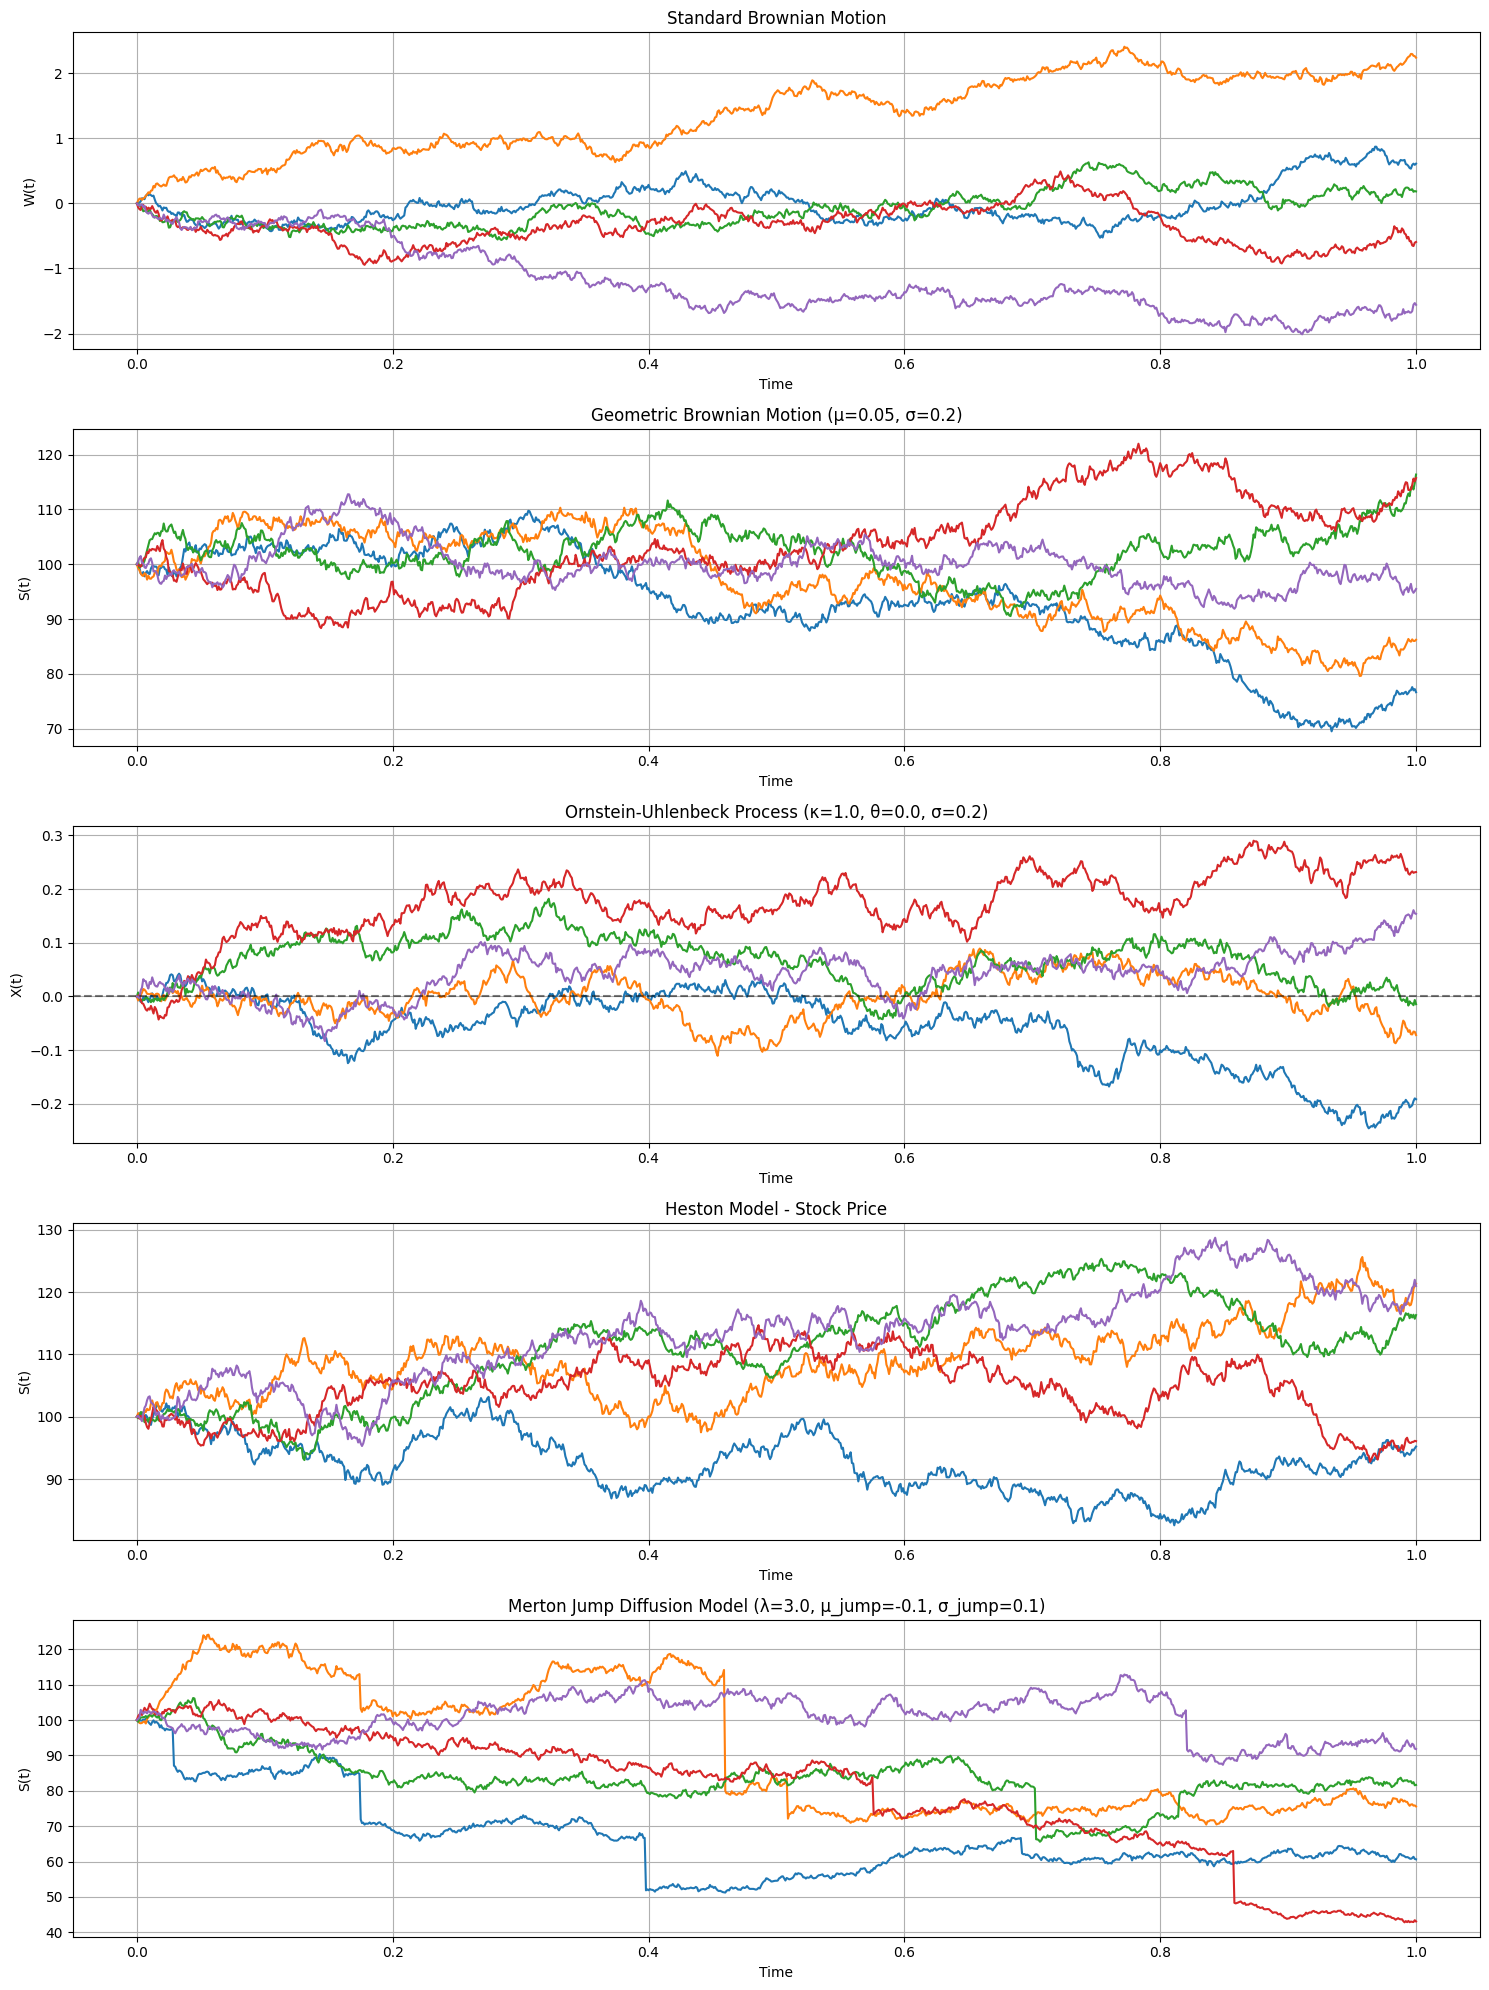

Stochastic processes module tested successfully


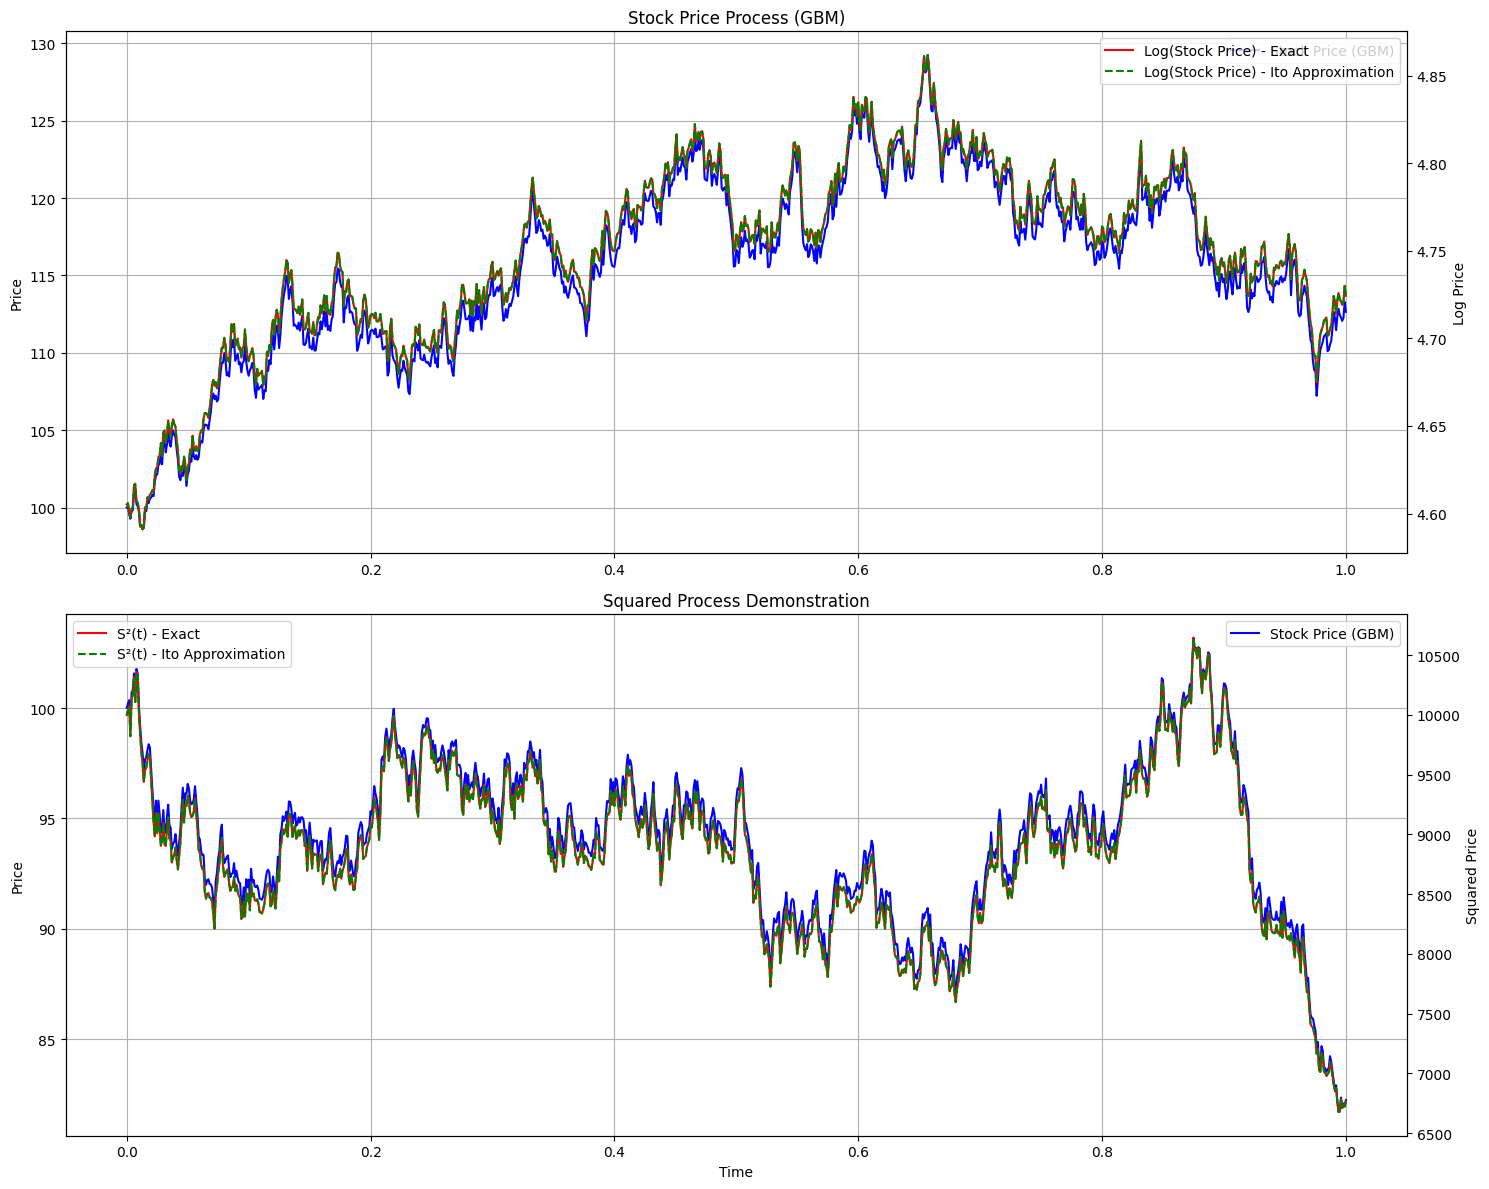


Black-Scholes PDE Derivation:

        # Black-Scholes PDE Derivation using Ito's Lemma
        
        The Black-Scholes Partial Differential Equation (PDE) is derived using Ito's lemma. 
        Here's how it works:

        ## 1. Assume the stock price follows a Geometric Brownian Motion (GBM):
           dS = μS dt + σS dW
           
           where:
           - S is the stock price
           - μ is the drift
           - σ is the volatility
           - dW is a Wiener process increment

        ## 2. Consider an option with price V(S,t) which depends on S and time t
           By Ito's lemma, the change in option price is:
           
           dV = (∂V/∂t)dt + (∂V/∂S)dS + (1/2)(∂²V/∂S²)(dS)²
           
           Substituting dS and noting that (dS)² = σ²S²dt (in the mean-square sense):
           
           dV = (∂V/∂t)dt + (∂V/∂S)[μS dt + σS dW] + (1/2)(∂²V/∂S²)σ²S²dt
           
           dV = [(∂V/∂t) + μS(∂V/∂S) + (1/2)σ²S²(∂²V/∂S²)]dt + σS(∂V/∂S)dW

        ## 3. 

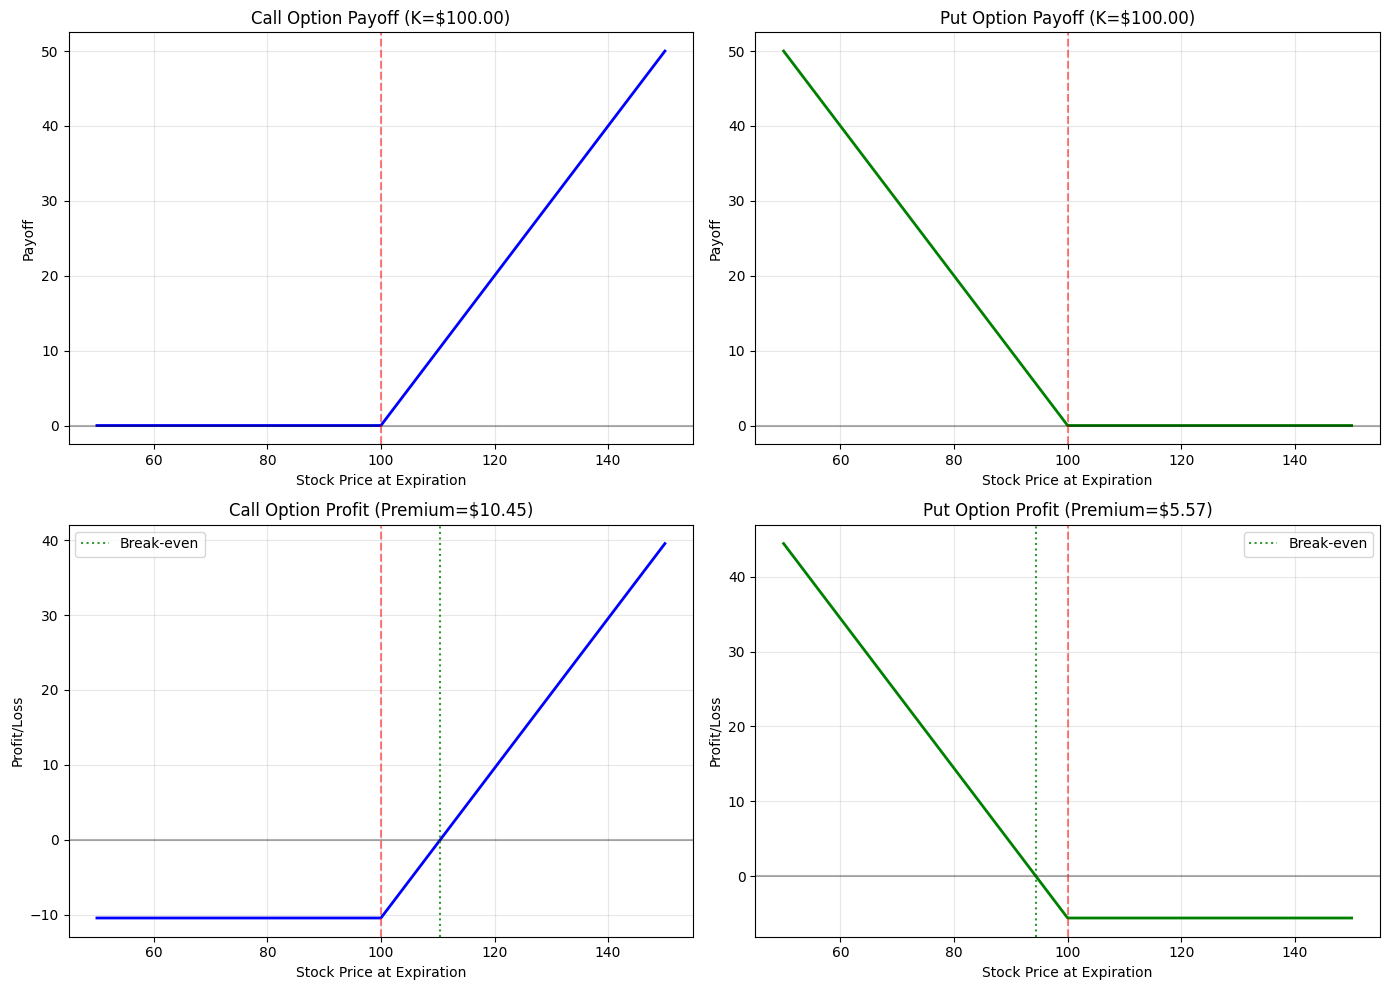

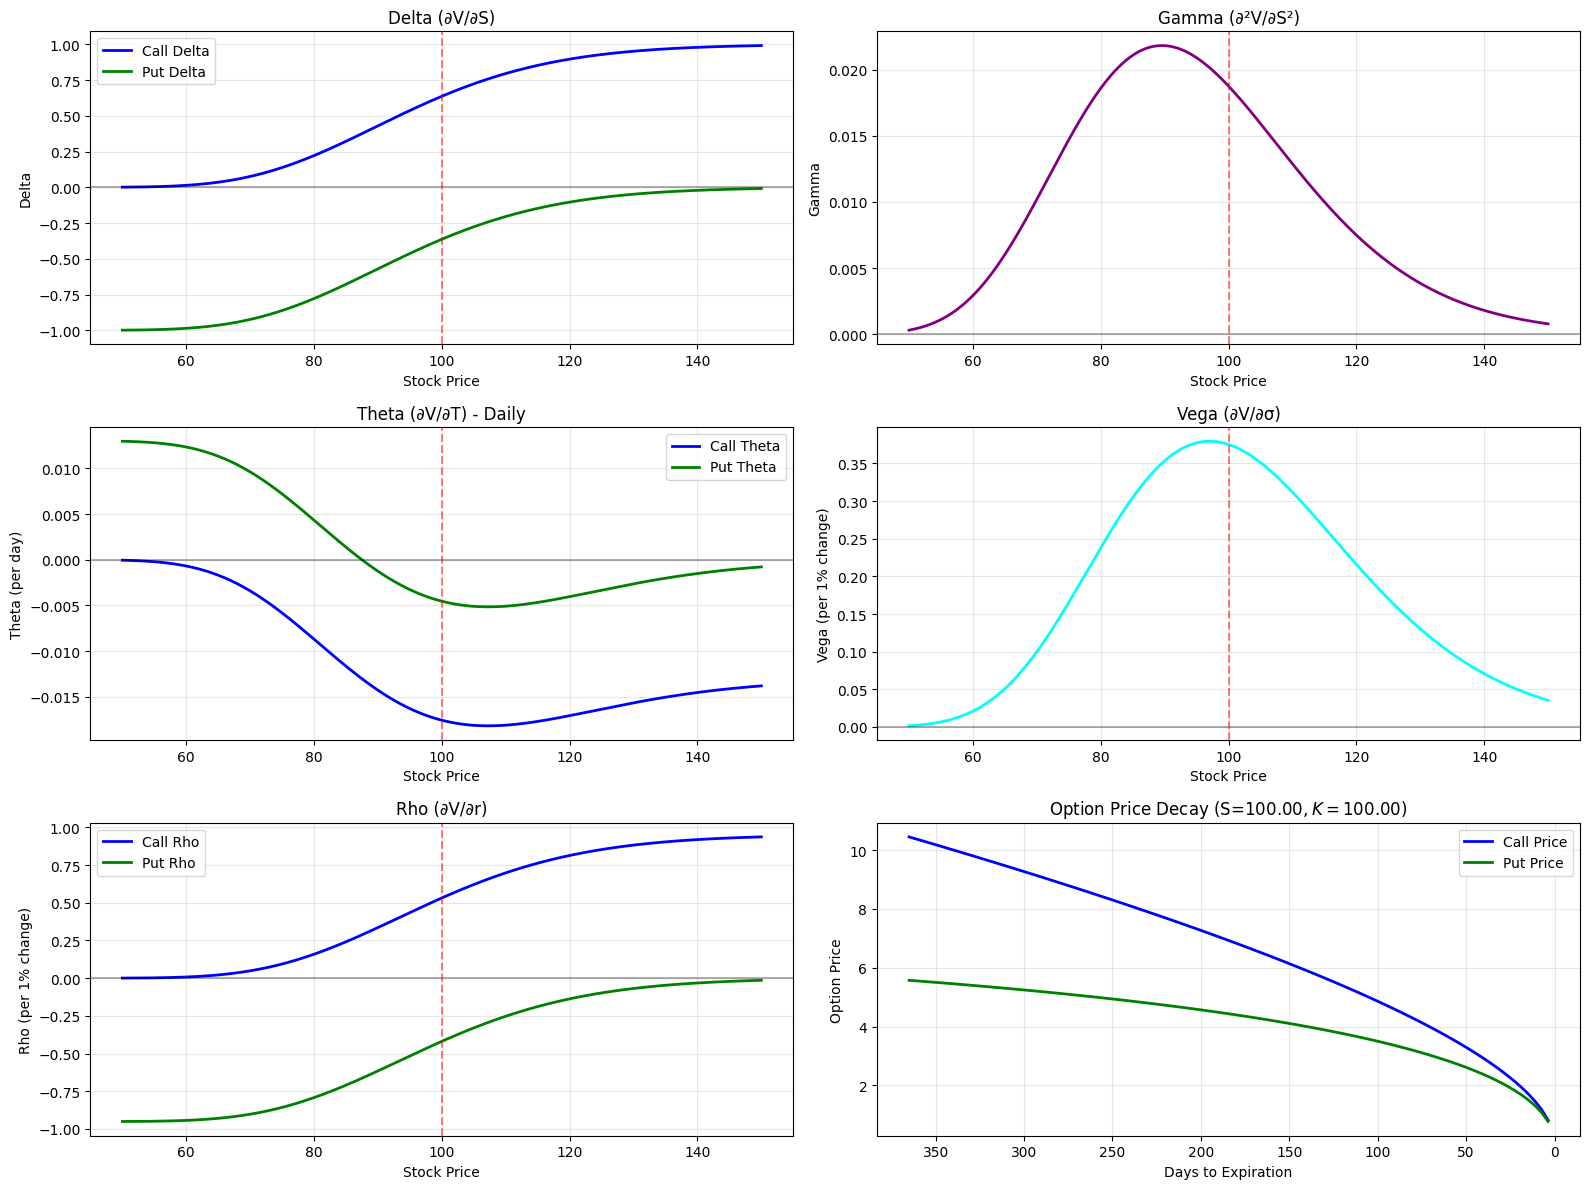

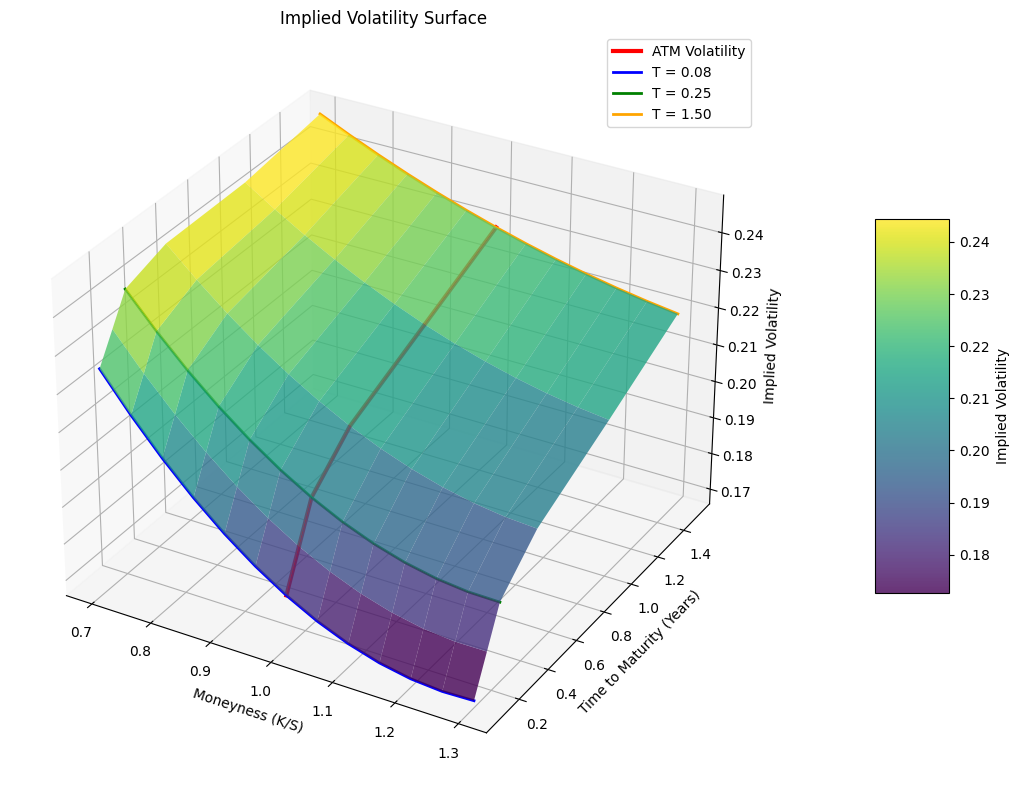

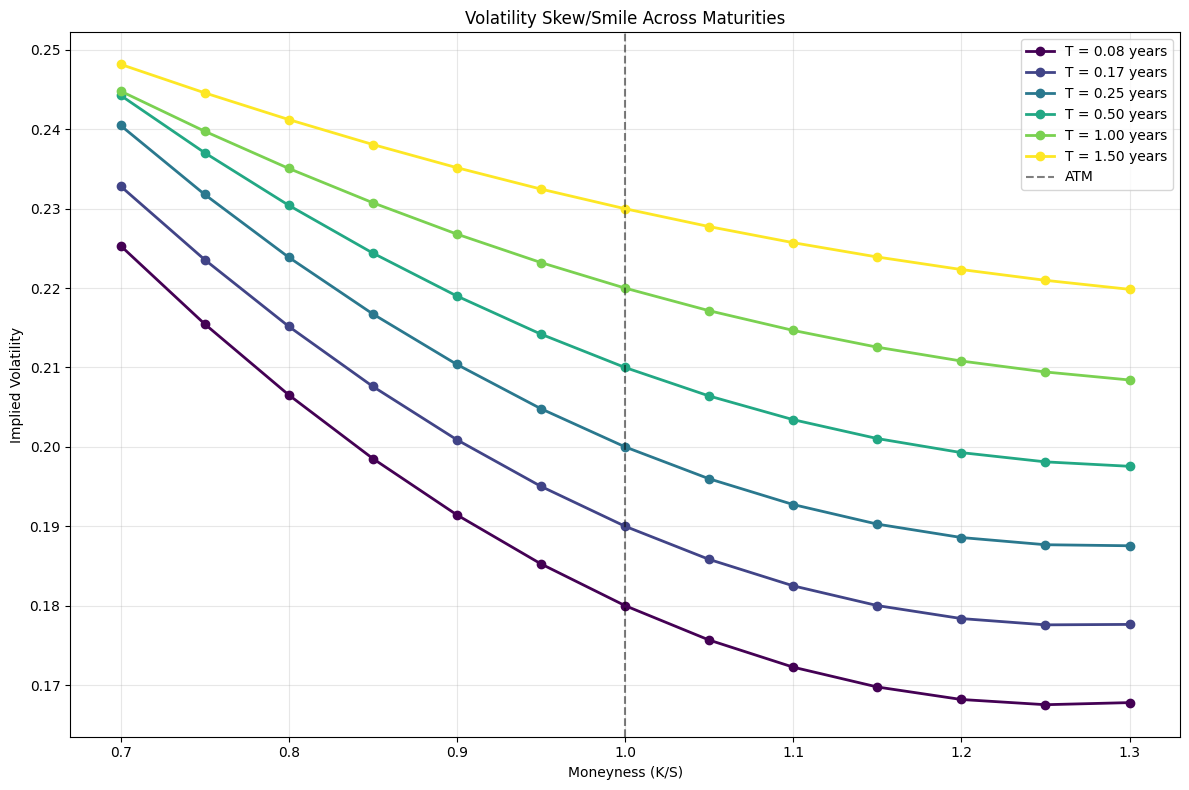

Black-Scholes-Merton model tested successfully


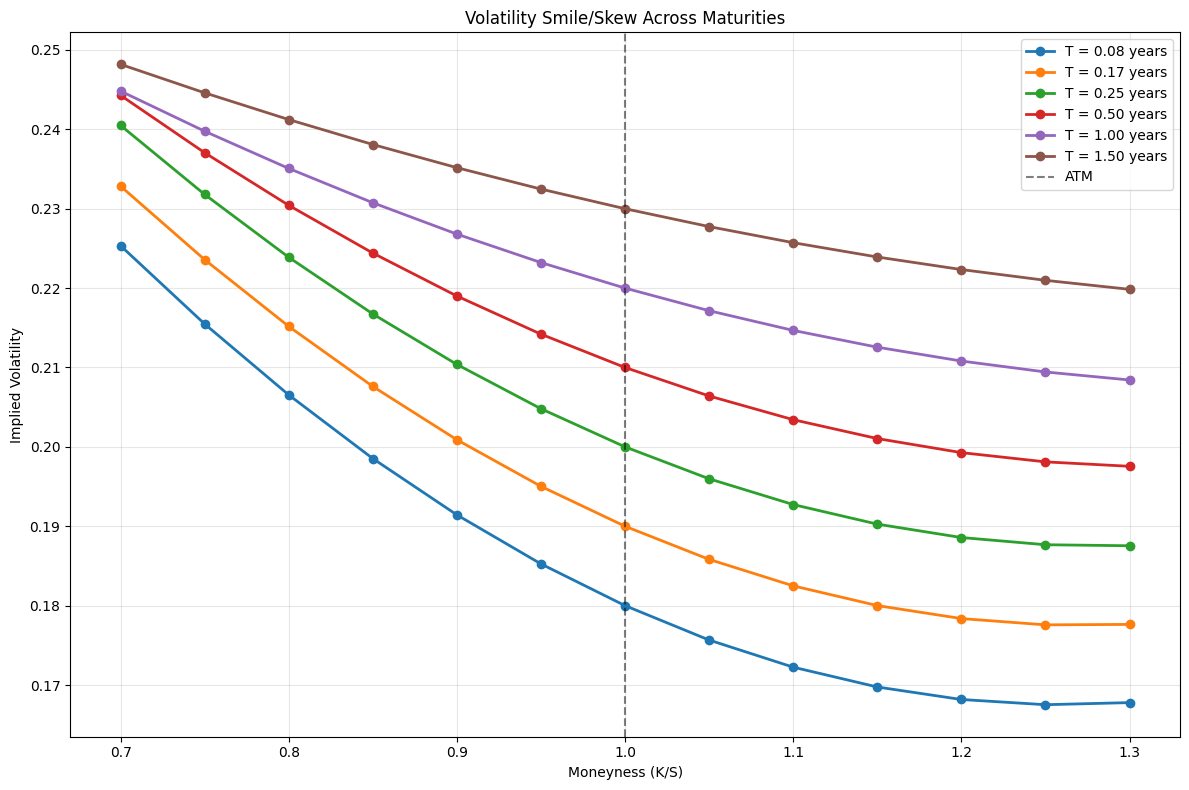

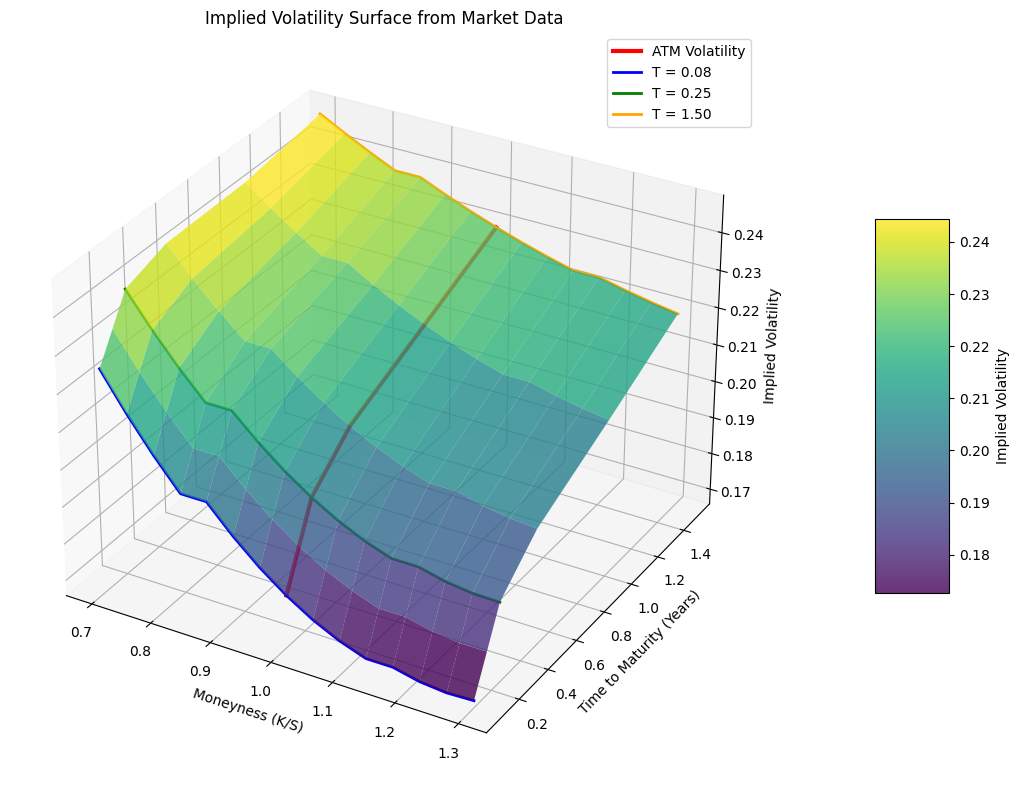

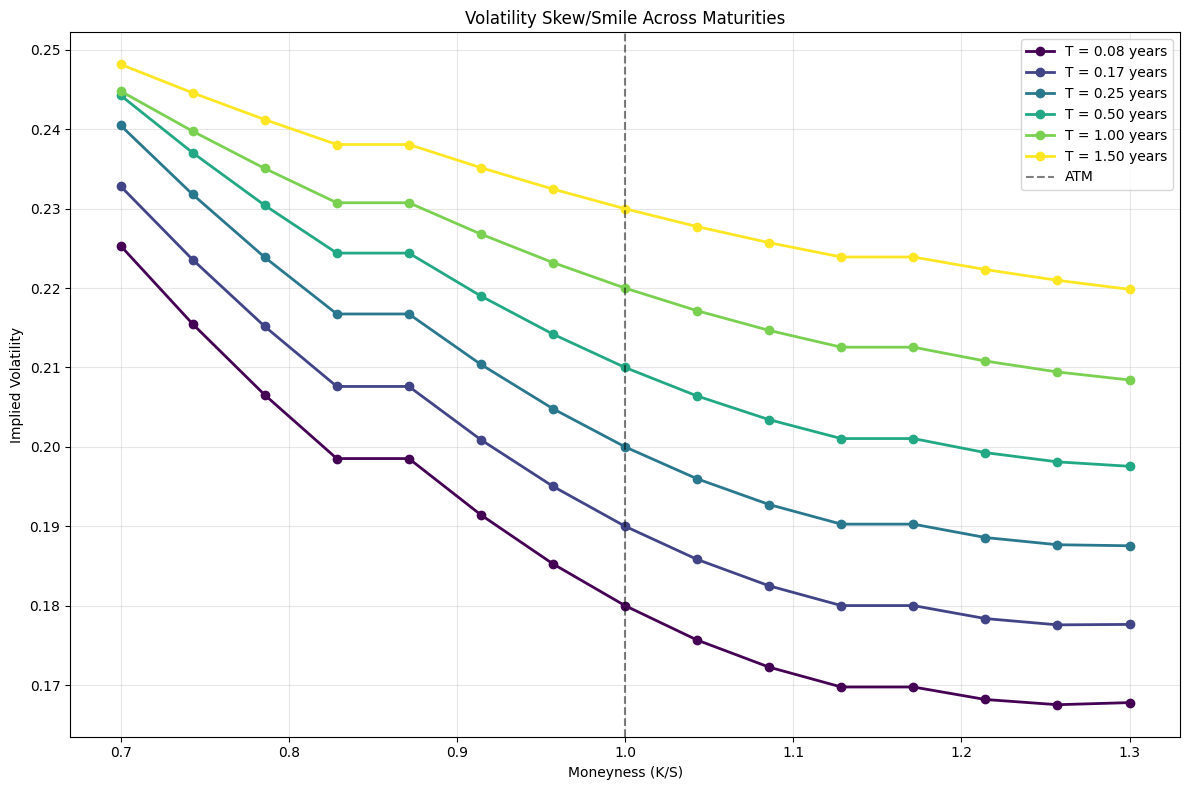


Volatility Regime Analysis:
Overall regime: Mixed Regime
Volatility level: Normal Volatility
Term structure: Moderate Contango
Shape: Symmetric (Rare)
Average ATM volatility: 20.50%

Volatility Spread Analysis:
Found 6 potential trading opportunities
Opportunity 1: Calendar Spread - Sell (Z-score: 2.45)
  Rationale: Term structure is unusually steep
Opportunity 2: Calendar Spread - Sell (Z-score: 2.82)
  Rationale: Term structure is unusually steep
Opportunity 3: Calendar Spread - Sell (Z-score: 2.06)
  Rationale: Term structure is unusually steep
Opportunity 4: Calendar Spread - Sell (Z-score: 1.54)
  Rationale: Term structure is unusually steep
Opportunity 5: Calendar Spread - Sell (Z-score: 3.30)
  Rationale: Term structure is unusually steep
Opportunity 6: Calendar Spread - Sell (Z-score: 1.90)
  Rationale: Term structure is unusually steep
Implied volatility analysis tested successfully

Monte Carlo European Call Price: $10.4286 (SE: 0.1460)
Monte Carlo Asian Call Price: $5.8501


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import optimize
import time
from tqdm import tqdm
import os
from numba import jit, prange
import warnings
warnings.filterwarnings('ignore')

class StochasticProcesses:
    """
    Implementation of various stochastic processes for financial modeling,
    with focus on Brownian motion and related processes.
    """
    
    def __init__(self, seed=None):
        """
        Initialize the stochastic processes generator
        
        Parameters:
        -----------
        seed : int, optional
            Random seed for reproducibility
        """
        if seed is not None:
            np.random.seed(seed)
    
    def brownian_motion(self, T=1.0, N=1000, paths=1):
        """
        Simulate a standard Brownian motion (Wiener process)
        W(t) with W(0) = 0
        
        Parameters:
        -----------
        T : float
            Time horizon
        N : int
            Number of time steps
        paths : int
            Number of simulation paths
            
        Returns:
        --------
        tuple: (time points, simulated paths)
        """
        dt = T/N
        t = np.linspace(0, T, N+1)
        
        # Initialize array for paths
        W = np.zeros((paths, N+1))
        
        # Generate independent Gaussian increments
        dW = np.random.normal(0, np.sqrt(dt), (paths, N))
        
        # Compute the Brownian motion paths
        W[:, 1:] = np.cumsum(dW, axis=1)
        
        return t, W
    
    def geometric_brownian_motion(self, S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000, paths=1):
        """
        Simulate a geometric Brownian motion (GBM)
        dS(t) = μS(t)dt + σS(t)dW(t)
        
        Parameters:
        -----------
        S0 : float
            Initial asset price
        mu : float
            Drift (annualized)
        sigma : float
            Volatility (annualized)
        T : float
            Time horizon
        N : int
            Number of time steps
        paths : int
            Number of simulation paths
            
        Returns:
        --------
        tuple: (time points, simulated paths)
        """
        dt = T/N
        t = np.linspace(0, T, N+1)
        
        # Generate Brownian motion
        _, W = self.brownian_motion(T=T, N=N, paths=paths)
        
        # Initialize array for GBM paths
        S = np.zeros((paths, N+1))
        S[:, 0] = S0
        
        # Compute the GBM paths
        for i in range(1, N+1):
            S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * (W[:, i] - W[:, i-1]))
        
        return t, S
    
    def gbm_exact(self, S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000, paths=1):
        """
        Simulate a geometric Brownian motion (GBM) using the exact solution
        S(t) = S0 * exp((μ - 0.5σ²)t + σW(t))
        
        Parameters:
        -----------
        S0 : float
            Initial asset price
        mu : float
            Drift (annualized)
        sigma : float
            Volatility (annualized)
        T : float
            Time horizon
        N : int
            Number of time steps
        paths : int
            Number of simulation paths
            
        Returns:
        --------
        tuple: (time points, simulated paths)
        """
        t = np.linspace(0, T, N+1)
        
        # Generate Brownian motion
        _, W = self.brownian_motion(T=T, N=N, paths=paths)
        
        # Compute exact solution
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        return t, S
    
    def mean_reverting_process(self, X0=0, kappa=1.0, theta=0.0, sigma=0.2, T=1.0, N=1000, paths=1):
        """
        Simulate an Ornstein-Uhlenbeck (mean-reverting) process
        dX(t) = κ(θ - X(t))dt + σdW(t)
        
        Parameters:
        -----------
        X0 : float
            Initial value
        kappa : float
            Mean reversion speed
        theta : float
            Long-term mean
        sigma : float
            Volatility
        T : float
            Time horizon
        N : int
            Number of time steps
        paths : int
            Number of simulation paths
            
        Returns:
        --------
        tuple: (time points, simulated paths)
        """
        dt = T/N
        t = np.linspace(0, T, N+1)
        
        # Initialize array for paths
        X = np.zeros((paths, N+1))
        X[:, 0] = X0
        
        # Generate standard Brownian motion increments
        dW = np.random.normal(0, np.sqrt(dt), (paths, N))
        
        # Simulate the OU process using Euler-Maruyama
        for i in range(1, N+1):
            X[:, i] = X[:, i-1] + kappa * (theta - X[:, i-1]) * dt + sigma * dW[:, i-1]
        
        return t, X
    
    def heston_model(self, S0=100, v0=0.04, rho=-0.7, kappa=1.0, theta=0.04, xi=0.1, 
                    r=0.0, T=1.0, N=1000, paths=1):
        """
        Simulate the Heston stochastic volatility model
        dS(t) = rS(t)dt + √v(t)S(t)dW₁(t)
        dv(t) = κ(θ - v(t))dt + ξ√v(t)dW₂(t)
        with correlation ρ between W₁ and W₂
        
        Parameters:
        -----------
        S0 : float
            Initial asset price
        v0 : float
            Initial variance
        rho : float
            Correlation between asset returns and variance process
        kappa : float
            Mean reversion speed of variance
        theta : float
            Long-term variance
        xi : float
            Volatility of variance
        r : float
            Risk-free rate
        T : float
            Time horizon
        N : int
            Number of time steps
        paths : int
            Number of simulation paths
            
        Returns:
        --------
        tuple: (time points, stock price paths, variance paths)
        """
        dt = T/N
        t = np.linspace(0, T, N+1)
        
        # Initialize arrays for stock price and variance paths
        S = np.zeros((paths, N+1))
        v = np.zeros((paths, N+1))
        S[:, 0] = S0
        v[:, 0] = v0
        
        # Generate correlated Brownian motions
        # Generate standard normal increments for the stock
        Z1 = np.random.normal(0, 1, (paths, N))
        # Generate correlated standard normal increments for the variance
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, (paths, N))
        
        # Scale to Brownian motion increments
        dW1 = Z1 * np.sqrt(dt)
        dW2 = Z2 * np.sqrt(dt)
        
        # Simulate the processes using a modified Euler scheme with reflection
        for i in range(1, N+1):
            # Ensure variance is positive
            v[:, i-1] = np.maximum(v[:, i-1], 0)
            
            # Update stock price
            S[:, i] = S[:, i-1] * np.exp((r - 0.5 * v[:, i-1]) * dt + np.sqrt(v[:, i-1]) * dW1[:, i-1])
            
            # Update variance using a scheme with reflection for stability
            v[:, i] = np.abs(v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + xi * np.sqrt(v[:, i-1]) * dW2[:, i-1])
        
        return t, S, v
    
    def jump_diffusion(self, S0=100, mu=0.05, sigma=0.2, lambda_jump=1.0, 
                     mu_jump=-0.1, sigma_jump=0.1, T=1.0, N=1000, paths=1):
        """
        Simulate a Merton jump diffusion model
        dS(t) = μS(t)dt + σS(t)dW(t) + S(t-)(e^J - 1)dN(t)
        where N(t) is a Poisson process with intensity λ,
        and J is normally distributed with mean μ_J and std dev σ_J
        
        Parameters:
        -----------
        S0 : float
            Initial asset price
        mu : float
            Drift (annualized)
        sigma : float
            Volatility (annualized)
        lambda_jump : float
            Jump intensity (average number of jumps per year)
        mu_jump : float
            Mean jump size
        sigma_jump : float
            Standard deviation of jump size
        T : float
            Time horizon
        N : int
            Number of time steps
        paths : int
            Number of simulation paths
            
        Returns:
        --------
        tuple: (time points, simulated paths, jump times)
        """
        dt = T/N
        t = np.linspace(0, T, N+1)
        
        # Initialize array for paths
        S = np.zeros((paths, N+1))
        S[:, 0] = S0
        
        # Generate Brownian motion
        _, W = self.brownian_motion(T=T, N=N, paths=paths)
        
        # Generate jump process
        jump_times = []
        for p in range(paths):
            # Number of jumps for this path (Poisson distribution)
            n_jumps = np.random.poisson(lambda_jump * T)
            
            # Jump times (uniform distribution)
            if n_jumps > 0:
                path_jump_times = np.sort(np.random.uniform(0, T, n_jumps))
                jump_times.append(path_jump_times)
            else:
                jump_times.append(np.array([]))
        
        # Simulate the jump diffusion process
        for p in range(paths):
            # Continuous part (GBM)
            for i in range(1, N+1):
                S[p, i] = S[p, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * (W[p, i] - W[p, i-1]))
            
            # Add jumps
            if len(jump_times[p]) > 0:
                for jump_time in jump_times[p]:
                    # Find the index corresponding to this jump time
                    idx = int(np.floor(jump_time / dt))
                    if idx >= N:
                        idx = N - 1  # Ensure valid index
                    
                    # Generate jump size
                    jump_size = np.random.normal(mu_jump, sigma_jump)
                    
                    # Apply jump to all points after the jump
                    S[p, idx+1:] *= np.exp(jump_size)
        
        return t, S, jump_times
    
    def plot_processes(self, num_paths=5, figsize=(15, 20)):
        """
        Generate and plot examples of different stochastic processes
        
        Parameters:
        -----------
        num_paths : int
            Number of paths to simulate for each process
        figsize : tuple
            Figure size
        """
        fig, axes = plt.subplots(5, 1, figsize=figsize)
        
        # Standard Brownian motion
        t, W = self.brownian_motion(T=1.0, N=1000, paths=num_paths)
        for i in range(num_paths):
            axes[0].plot(t, W[i])
        axes[0].set_title('Standard Brownian Motion')
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('W(t)')
        axes[0].grid(True)
        
        # Geometric Brownian motion
        t, S = self.geometric_brownian_motion(S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000, paths=num_paths)
        for i in range(num_paths):
            axes[1].plot(t, S[i])
        axes[1].set_title('Geometric Brownian Motion (μ=0.05, σ=0.2)')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('S(t)')
        axes[1].grid(True)
        
        # Mean-reverting process
        t, X = self.mean_reverting_process(X0=0, kappa=1.0, theta=0.0, sigma=0.2, T=1.0, N=1000, paths=num_paths)
        for i in range(num_paths):
            axes[2].plot(t, X[i])
        axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.5)  # Long-term mean
        axes[2].set_title('Ornstein-Uhlenbeck Process (κ=1.0, θ=0.0, σ=0.2)')
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('X(t)')
        axes[2].grid(True)
        
        # Heston model
        t, S, v = self.heston_model(S0=100, v0=0.04, rho=-0.7, kappa=1.0, theta=0.04, xi=0.1,
                                    r=0.0, T=1.0, N=1000, paths=num_paths)
        
        # Plot stock prices
        for i in range(num_paths):
            axes[3].plot(t, S[i])
        axes[3].set_title('Heston Model - Stock Price')
        axes[3].set_xlabel('Time')
        axes[3].set_ylabel('S(t)')
        axes[3].grid(True)
        
        # Jump diffusion model
        t, S, _ = self.jump_diffusion(S0=100, mu=0.05, sigma=0.2, lambda_jump=3.0,
                                     mu_jump=-0.1, sigma_jump=0.1, T=1.0, N=1000, paths=num_paths)
        for i in range(num_paths):
            axes[4].plot(t, S[i])
        axes[4].set_title('Merton Jump Diffusion Model (λ=3.0, μ_jump=-0.1, σ_jump=0.1)')
        axes[4].set_xlabel('Time')
        axes[4].set_ylabel('S(t)')
        axes[4].grid(True)
        
        plt.tight_layout()
        plt.savefig("stochastic_processes.png", dpi=300)
        plt.show()
        
        return fig


class ItoCalculus:
    """
    Implementation of Ito calculus applications for financial models.
    """
    
    def __init__(self):
        """Initialize Ito calculus utilities"""
        self.sp = StochasticProcesses()
    
    def ito_formula_demo(self, f, df, ddf, process='gbm', S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000):
        """
        Demonstrate Ito's formula for a function of a stochastic process
        For f(X_t), Ito's formula gives:
        df(X_t) = f'(X_t)dX_t + (1/2)f''(X_t)(dX_t)^2
        
        Parameters:
        -----------
        f : function
            The function f(x) to apply to the process
        df : function
            First derivative f'(x)
        ddf : function
            Second derivative f''(x)
        process : str
            Type of stochastic process ('gbm' or 'bm')
        S0, mu, sigma : float
            Parameters for GBM
        T, N : float, int
            Time horizon and number of steps
            
        Returns:
        --------
        tuple: (time points, original process, transformed process, approximated transform)
        """
        dt = T/N
        t = np.linspace(0, T, N+1)
        
        # Generate the stochastic process
        if process == 'gbm':
            _, X = self.sp.geometric_brownian_motion(S0=S0, mu=mu, sigma=sigma, T=T, N=N, paths=1)
        else:  # Default to standard Brownian motion
            _, X = self.sp.brownian_motion(T=T, N=N, paths=1)
        
        X = X[0]  # Take the first path
        
        # Apply function to the process
        Y = np.zeros_like(X)
        Y_approx = np.zeros_like(X)
        
        # Initial value
        Y[0] = f(X[0])
        Y_approx[0] = f(X[0])
        
        # Apply Ito's formula
        for i in range(1, N+1):
            # Exact transform
            Y[i] = f(X[i])
            
            # Approximation using Ito's formula
            dX = X[i] - X[i-1]
            Y_approx[i] = Y_approx[i-1] + df(X[i-1]) * dX + 0.5 * ddf(X[i-1]) * (dX)**2
        
        return t, X, Y, Y_approx
    
    def log_process(self, S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000):
        """
        Apply Ito's formula to the logarithm of a GBM
        If X_t follows a GBM, then Y_t = log(X_t) follows:
        dY_t = (mu - 0.5*sigma^2)dt + sigma*dW_t
        
        Parameters:
        -----------
        S0, mu, sigma : float
            Parameters for GBM
        T, N : float, int
            Time horizon and number of steps
            
        Returns:
        --------
        tuple: (time points, stock price, log stock price, approximated log price)
        """
        # Define functions for log transform
        f = lambda x: np.log(x)
        df = lambda x: 1/x
        ddf = lambda x: -1/(x**2)
        
        return self.ito_formula_demo(f, df, ddf, process='gbm', 
                                    S0=S0, mu=mu, sigma=sigma, T=T, N=N)
    
    def squared_process(self, S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000):
        """
        Apply Ito's formula to the square of a GBM
        If X_t follows a GBM, then Y_t = X_t^2 follows:
        dY_t = [(2*mu + sigma^2)Y_t]dt + [2*sigma*Y_t]dW_t
        
        Parameters:
        -----------
        S0, mu, sigma : float
            Parameters for GBM
        T, N : float, int
            Time horizon and number of steps
            
        Returns:
        --------
        tuple: (time points, stock price, squared stock price, approximated squared price)
        """
        # Define functions for square transform
        f = lambda x: x**2
        df = lambda x: 2*x
        ddf = lambda x: 2
        
        return self.ito_formula_demo(f, df, ddf, process='gbm', 
                                    S0=S0, mu=mu, sigma=sigma, T=T, N=N)
    
    def plot_ito_formula_examples(self, figsize=(15, 12)):
        """
        Generate and plot examples of Ito's formula
        
        Parameters:
        -----------
        figsize : tuple
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure: The generated figure
        """
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        
        # Example 1: Log process
        t, S, logS, logS_approx = self.log_process(S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000)
        
        axes[0].plot(t, S, 'b-', label='Stock Price (GBM)')
        axes[0].set_ylabel('Price')
        axes[0].set_title('Stock Price Process (GBM)')
        axes[0].grid(True)
        axes[0].legend()
        
        # Twin axis for log price
        ax0_twin = axes[0].twinx()
        ax0_twin.plot(t, logS, 'r-', label='Log(Stock Price) - Exact')
        ax0_twin.plot(t, logS_approx, 'g--', label='Log(Stock Price) - Ito Approximation')
        ax0_twin.set_ylabel('Log Price')
        ax0_twin.legend()
        
        # Example 2: Squared process
        t, S, S_squared, S_squared_approx = self.squared_process(S0=100, mu=0.05, sigma=0.2, T=1.0, N=1000)
        
        axes[1].plot(t, S, 'b-', label='Stock Price (GBM)')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Price')
        axes[1].set_title('Squared Process Demonstration')
        axes[1].grid(True)
        axes[1].legend()
        
        # Twin axis for squared price
        ax1_twin = axes[1].twinx()
        ax1_twin.plot(t, S_squared, 'r-', label='S²(t) - Exact')
        ax1_twin.plot(t, S_squared_approx, 'g--', label='S²(t) - Ito Approximation')
        ax1_twin.set_ylabel('Squared Price')
        ax1_twin.legend()
        
        plt.tight_layout()
        plt.savefig("ito_formula_examples.png", dpi=300)
        plt.show()
        
        return fig
    
    def black_scholes_pde_derivation(self):
        """
        Explain the derivation of the Black-Scholes PDE using Ito's lemma
        
        Returns:
        --------
        str: Explanation of the derivation
        """
        explanation = """
        # Black-Scholes PDE Derivation using Ito's Lemma
        
        The Black-Scholes Partial Differential Equation (PDE) is derived using Ito's lemma. 
        Here's how it works:

        ## 1. Assume the stock price follows a Geometric Brownian Motion (GBM):
           dS = μS dt + σS dW
           
           where:
           - S is the stock price
           - μ is the drift
           - σ is the volatility
           - dW is a Wiener process increment

        ## 2. Consider an option with price V(S,t) which depends on S and time t
           By Ito's lemma, the change in option price is:
           
           dV = (∂V/∂t)dt + (∂V/∂S)dS + (1/2)(∂²V/∂S²)(dS)²
           
           Substituting dS and noting that (dS)² = σ²S²dt (in the mean-square sense):
           
           dV = (∂V/∂t)dt + (∂V/∂S)[μS dt + σS dW] + (1/2)(∂²V/∂S²)σ²S²dt
           
           dV = [(∂V/∂t) + μS(∂V/∂S) + (1/2)σ²S²(∂²V/∂S²)]dt + σS(∂V/∂S)dW

        ## 3. Create a risk-free portfolio by hedging:
           Π = V - Δ·S where Δ = ∂V/∂S (delta hedging)
           
           The change in portfolio value is:
           dΠ = dV - Δ·dS
           
           Substituting:
           dΠ = [(∂V/∂t) + μS(∂V/∂S) + (1/2)σ²S²(∂²V/∂S²)]dt + σS(∂V/∂S)dW - (∂V/∂S)[μS dt + σS dW]
           
           dΠ = [(∂V/∂t) + (1/2)σ²S²(∂²V/∂S²)]dt
           
           Note that the random term dW has been eliminated - the portfolio is now risk-free.

        ## 4. Apply the no-arbitrage principle:
           The return on this risk-free portfolio must equal the risk-free rate:
           dΠ = rΠdt
           
           Since Π = V - Δ·S = V - (∂V/∂S)·S:
           [(∂V/∂t) + (1/2)σ²S²(∂²V/∂S²)]dt = r[V - (∂V/∂S)·S]dt

        ## 5. Rearranging gives the Black-Scholes PDE:
           (∂V/∂t) + (1/2)σ²S²(∂²V/∂S²) + rS(∂V/∂S) - rV = 0
        
        This PDE describes how the option price V(S,t) evolves over time. Given appropriate 
        boundary conditions (payoff at expiration), we can solve this PDE to obtain the 
        Black-Scholes formula for European options.
        """
        
        return explanation


class BSMOptionPricing:
    """
    Black-Scholes-Merton model implementation for option pricing.
    """
    
    def __init__(self, risk_free_rate=0.05, dividend_yield=0.0):
        """
        Initialize the BSM pricing model
        
        Parameters:
        -----------
        risk_free_rate : float
            Risk-free interest rate (annualized)
        dividend_yield : float
            Dividend yield (annualized)
        """
        self.risk_free_rate = risk_free_rate
        self.dividend_yield = dividend_yield
    
    def d1(self, S, K, T, r, sigma):
        """
        Calculate d1 parameter for the Black-Scholes formula
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
            
        Returns:
        --------
        float or array: d1 parameter
        """
        # Handle special case to avoid division by zero or log of zero
        if isinstance(T, (int, float)) and T <= 0 or (hasattr(T, '__iter__') and any(t <= 0 for t in T)):
            return np.nan
            
        if isinstance(S, (int, float)) and isinstance(K, (int, float)):
            if S <= 0 or K <= 0:
                return np.nan
        
        # Calculate d1
        return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S, K, T, r, sigma):
        """
        Calculate d2 parameter for the Black-Scholes formula
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
            
        Returns:
        --------
        float or array: d2 parameter
        """
        return self.d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
    def call_price(self, S, K, T, r, sigma, q=None):
        """
        Calculate price of a European call option
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Call option price
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return np.maximum(0, S - K)
        
        # Calculate d1 and d2
        d1_val = self.d1(S, K, T, r - q, sigma)
        d2_val = d2 = d1_val - sigma * np.sqrt(T)
        
        # Calculate call price
        call = S * np.exp(-q * T) * norm.cdf(d1_val) - K * np.exp(-r * T) * norm.cdf(d2_val)
        
        return call
    
    def put_price(self, S, K, T, r, sigma, q=None):
        """
        Calculate price of a European put option
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Put option price
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return np.maximum(0, K - S)
        
        # Calculate d1 and d2
        d1_val = self.d1(S, K, T, r - q, sigma)
        d2_val = d1_val - sigma * np.sqrt(T)
        
        # Calculate put price
        put = K * np.exp(-r * T) * norm.cdf(-d2_val) - S * np.exp(-q * T) * norm.cdf(-d1_val)
        
        return put
    
    def call_delta(self, S, K, T, r, sigma, q=None):
        """
        Calculate delta of a European call option
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Call option delta
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return 1.0 if S > K else 0.0
        
        # Calculate d1
        d1_val = self.d1(S, K, T, r - q, sigma)
        
        # Calculate call delta
        return np.exp(-q * T) * norm.cdf(d1_val)
    
    def put_delta(self, S, K, T, r, sigma, q=None):
        """
        Calculate delta of a European put option
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Put option delta
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return -1.0 if S < K else 0.0
        
        # Calculate d1
        d1_val = self.d1(S, K, T, r - q, sigma)
        
        # Calculate put delta
        return -np.exp(-q * T) * norm.cdf(-d1_val)
    
    def gamma(self, S, K, T, r, sigma, q=None):
        """
        Calculate gamma of an option (same for calls and puts)
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Option gamma
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return 0.0
        
        # Calculate d1
        d1_val = self.d1(S, K, T, r - q, sigma)
        
        # Calculate gamma
        return np.exp(-q * T) * norm.pdf(d1_val) / (S * sigma * np.sqrt(T))
    
    def call_theta(self, S, K, T, r, sigma, q=None):
        """
        Calculate theta of a European call option (time decay)
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Call option theta (per year)
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return 0.0
        
        # Calculate d1 and d2
        d1_val = self.d1(S, K, T, r - q, sigma)
        d2_val = d1_val - sigma * np.sqrt(T)
        
        # Calculate call theta (per year)
        term1 = -np.exp(-q * T) * S * norm.pdf(d1_val) * sigma / (2 * np.sqrt(T))
        term2 = -r * K * np.exp(-r * T) * norm.cdf(d2_val)
        term3 = q * S * np.exp(-q * T) * norm.cdf(d1_val)
        
        return term1 + term2 + term3
    
    def put_theta(self, S, K, T, r, sigma, q=None):
        """
        Calculate theta of a European put option (time decay)
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Put option theta (per year)
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return 0.0
        
        # Calculate d1 and d2
        d1_val = self.d1(S, K, T, r - q, sigma)
        d2_val = d1_val - sigma * np.sqrt(T)
        
        # Calculate put theta (per year)
        term1 = -np.exp(-q * T) * S * norm.pdf(d1_val) * sigma / (2 * np.sqrt(T))
        term2 = r * K * np.exp(-r * T) * norm.cdf(-d2_val)
        term3 = -q * S * np.exp(-q * T) * norm.cdf(-d1_val)
        
        return term1 + term2 + term3
    
    def vega(self, S, K, T, r, sigma, q=None):
        """
        Calculate vega of an option (same for calls and puts)
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Option vega (per 1% change in volatility)
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return 0.0
        
        # Calculate d1
        d1_val = self.d1(S, K, T, r - q, sigma)
        
        # Calculate vega (per 1% change)
        return 0.01 * S * np.exp(-q * T) * norm.pdf(d1_val) * np.sqrt(T)
    
    def call_rho(self, S, K, T, r, sigma, q=None):
        """
        Calculate rho of a European call option (sensitivity to interest rate)
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Call option rho (per 1% change in interest rate)
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return 0.0
        
        # Calculate d2
        d2_val = self.d2(S, K, T, r - q, sigma)
        
        # Calculate call rho (per 1% change)
        return 0.01 * K * T * np.exp(-r * T) * norm.cdf(d2_val)
    
    def put_rho(self, S, K, T, r, sigma, q=None):
        """
        Calculate rho of a European put option (sensitivity to interest rate)
        
        Parameters:
        -----------
        S : float or array
            Current stock price
        K : float or array
            Strike price
        T : float or array
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
            
        Returns:
        --------
        float or array: Put option rho (per 1% change in interest rate)
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if isinstance(T, (int, float)) and T <= 0:
            return 0.0
        
        # Calculate d2
        d2_val = self.d2(S, K, T, r - q, sigma)
        
        # Calculate put rho (per 1% change)
        return -0.01 * K * T * np.exp(-r * T) * norm.cdf(-d2_val)
    
    def implied_volatility(self, price, S, K, T, r, option_type='call', q=None,
                          max_iterations=100, precision=1e-8):
        """
        Calculate implied volatility using Newton-Raphson method
        
        Parameters:
        -----------
        price : float
            Market price of the option
        S : float
            Current stock price
        K : float
            Strike price
        T : float
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        option_type : str
            Option type ('call' or 'put')
        q : float, optional
            Dividend yield (annualized), defaults to instance value if None
        max_iterations : int
            Maximum number of iterations for numerical method
        precision : float
            Desired precision for implied volatility
            
        Returns:
        --------
        float: Implied volatility
        """
        # Use instance dividend yield if not provided
        if q is None:
            q = self.dividend_yield
        
        # Handle expired options
        if T <= 0:
            if option_type.lower() == 'call':
                intrinsic = max(0, S - K)
            else:
                intrinsic = max(0, K - S)
            
            if abs(price - intrinsic) < 1e-6:
                return 0.0  # At intrinsic value
            else:
                return np.nan  # Invalid price for expired option
        
        # Check if price is below intrinsic value
        if option_type.lower() == 'call':
            intrinsic = max(0, S - K * np.exp(-r * T))
        else:
            intrinsic = max(0, K * np.exp(-r * T) - S)
        
        if price < intrinsic:
            return np.nan  # Price below intrinsic value
        
        # Initial guess based on simple approximation
        # For ATM options, initial vol around 20-30% is reasonable
        moneyness = S/K
        if 0.8 <= moneyness <= 1.2:  # Near ATM
            sigma = 0.25
        elif moneyness < 0.8:  # Deep ITM for puts, OTM for calls
            sigma = 0.35
        else:  # Deep OTM for puts, ITM for calls
            sigma = 0.35
        
        # Define the pricing function based on option type
        if option_type.lower() == 'call':
            price_function = lambda vol: self.call_price(S, K, T, r, vol, q)
            vega_function = lambda vol: self.vega(S, K, T, r, vol, q) * 100  # Scale vega
        else:
            price_function = lambda vol: self.put_price(S, K, T, r, vol, q)
            vega_function = lambda vol: self.vega(S, K, T, r, vol, q) * 100  # Scale vega
        
        # Newton-Raphson method
        for i in range(max_iterations):
            # Calculate price and vega at current sigma
            model_price = price_function(sigma)
            vega = vega_function(sigma)
            
            # Calculate price difference
            price_diff = model_price - price
            
            # Check for convergence
            if abs(price_diff) < precision:
                return sigma
            
            # Avoid division by zero
            if abs(vega) < 1e-10:
                # If vega is too small, use bisection-like approach
                if price_diff > 0:
                    sigma = max(0.001, sigma * 0.9)  # Decrease sigma
                else:
                    sigma = min(5.0, sigma * 1.1)  # Increase sigma
            else:
                # Newton-Raphson update
                new_sigma = sigma - price_diff / vega
                
                # Ensure sigma stays within reasonable bounds
                if new_sigma <= 0.001:
                    sigma = 0.001
                elif new_sigma > 5.0:
                    sigma = 5.0
                else:
                    sigma = new_sigma
        
        # If no convergence, return NaN
        return np.nan
    
    def plot_option_payoffs(self, S0=100, K=100, T=1.0, r=0.05, sigma=0.2, q=0.0, figsize=(14, 10)):
        """
        Plot option payoffs and profit diagrams at expiration
        
        Parameters:
        -----------
        S0 : float
            Current stock price
        K : float
            Strike price
        T : float
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float
            Dividend yield (annualized)
        figsize : tuple
            Figure size
        
        Returns:
        --------
        matplotlib.figure.Figure: The generated figure
        """
        # Calculate option prices
        call_premium = self.call_price(S0, K, T, r, sigma, q)
        put_premium = self.put_price(S0, K, T, r, sigma, q)
        
        # Stock price range for payoff diagrams
        stock_prices = np.linspace(max(0.5, K*0.5), K*1.5, 1000)
        
        # Calculate payoffs at expiration
        call_payoff = np.maximum(0, stock_prices - K)
        put_payoff = np.maximum(0, K - stock_prices)
        
        # Calculate profit/loss at expiration
        call_profit = call_payoff - call_premium
        put_profit = put_payoff - put_premium
        
        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Plot call option payoff
        axes[0, 0].plot(stock_prices, call_payoff, 'b-', linewidth=2)
        axes[0, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[0, 0].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[0, 0].set_title(f'Call Option Payoff (K=${K:.2f})')
        axes[0, 0].set_xlabel('Stock Price at Expiration')
        axes[0, 0].set_ylabel('Payoff')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot put option payoff
        axes[0, 1].plot(stock_prices, put_payoff, 'g-', linewidth=2)
        axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[0, 1].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[0, 1].set_title(f'Put Option Payoff (K=${K:.2f})')
        axes[0, 1].set_xlabel('Stock Price at Expiration')
        axes[0, 1].set_ylabel('Payoff')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot call option profit
        axes[1, 0].plot(stock_prices, call_profit, 'b-', linewidth=2)
        axes[1, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 0].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[1, 0].axvline(x=K+call_premium, color='g', linestyle=':', alpha=0.8, label='Break-even')
        axes[1, 0].set_title(f'Call Option Profit (Premium=${call_premium:.2f})')
        axes[1, 0].set_xlabel('Stock Price at Expiration')
        axes[1, 0].set_ylabel('Profit/Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot put option profit
        axes[1, 1].plot(stock_prices, put_profit, 'g-', linewidth=2)
        axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 1].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[1, 1].axvline(x=K-put_premium, color='g', linestyle=':', alpha=0.8, label='Break-even')
        axes[1, 1].set_title(f'Put Option Profit (Premium=${put_premium:.2f})')
        axes[1, 1].set_xlabel('Stock Price at Expiration')
        axes[1, 1].set_ylabel('Profit/Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig("option_payoffs.png", dpi=300)
        plt.show()
        
        return fig

    def plot_greeks(self, S0=100, K=100, T=1.0, r=0.05, sigma=0.2, q=0.0, figsize=(16, 12)):
        """
        Plot option Greeks
        
        Parameters:
        -----------
        S0 : float
            Current stock price
        K : float
            Strike price
        T : float
            Time to expiration (in years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Implied volatility (annualized)
        q : float
            Dividend yield (annualized)
        figsize : tuple
            Figure size
        
        Returns:
        --------
        matplotlib.figure.Figure: The generated figure
        """
        # Stock price range for diagrams
        stock_prices = np.linspace(max(0.5, K*0.5), K*1.5, 1000)
        
        # Calculate Greeks for both call and put
        call_delta = np.array([self.call_delta(S, K, T, r, sigma, q) for S in stock_prices])
        put_delta = np.array([self.put_delta(S, K, T, r, sigma, q) for S in stock_prices])
        
        gamma = np.array([self.gamma(S, K, T, r, sigma, q) for S in stock_prices])
        
        call_theta = np.array([self.call_theta(S, K, T, r, sigma, q) for S in stock_prices])
        put_theta = np.array([self.put_theta(S, K, T, r, sigma, q) for S in stock_prices])
        
        vega = np.array([self.vega(S, K, T, r, sigma, q) for S in stock_prices])
        
        call_rho = np.array([self.call_rho(S, K, T, r, sigma, q) for S in stock_prices])
        put_rho = np.array([self.put_rho(S, K, T, r, sigma, q) for S in stock_prices])
        
        # Create figure
        fig, axes = plt.subplots(3, 2, figsize=figsize)
        
        # Plot Delta
        axes[0, 0].plot(stock_prices, call_delta, 'b-', linewidth=2, label='Call Delta')
        axes[0, 0].plot(stock_prices, put_delta, 'g-', linewidth=2, label='Put Delta')
        axes[0, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[0, 0].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[0, 0].set_title('Delta (∂V/∂S)')
        axes[0, 0].set_xlabel('Stock Price')
        axes[0, 0].set_ylabel('Delta')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot Gamma
        axes[0, 1].plot(stock_prices, gamma, 'purple', linewidth=2)
        axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[0, 1].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[0, 1].set_title('Gamma (∂²V/∂S²)')
        axes[0, 1].set_xlabel('Stock Price')
        axes[0, 1].set_ylabel('Gamma')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot Theta
        axes[1, 0].plot(stock_prices, call_theta/365, 'b-', linewidth=2, label='Call Theta')
        axes[1, 0].plot(stock_prices, put_theta/365, 'g-', linewidth=2, label='Put Theta')
        axes[1, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 0].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[1, 0].set_title('Theta (∂V/∂T) - Daily')
        axes[1, 0].set_xlabel('Stock Price')
        axes[1, 0].set_ylabel('Theta (per day)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot Vega
        axes[1, 1].plot(stock_prices, vega, 'cyan', linewidth=2)
        axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[1, 1].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[1, 1].set_title('Vega (∂V/∂σ)')
        axes[1, 1].set_xlabel('Stock Price')
        axes[1, 1].set_ylabel('Vega (per 1% change)')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot Rho
        axes[2, 0].plot(stock_prices, call_rho, 'b-', linewidth=2, label='Call Rho')
        axes[2, 0].plot(stock_prices, put_rho, 'g-', linewidth=2, label='Put Rho')
        axes[2, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[2, 0].axvline(x=K, color='r', linestyle='--', alpha=0.5)
        axes[2, 0].set_title('Rho (∂V/∂r)')
        axes[2, 0].set_xlabel('Stock Price')
        axes[2, 0].set_ylabel('Rho (per 1% change)')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        # Plot at-the-money option price decay over time
        times = np.linspace(0.01, T, 100)
        call_prices = np.array([self.call_price(S0, K, t, r, sigma, q) for t in times])
        put_prices = np.array([self.put_price(S0, K, t, r, sigma, q) for t in times])
        
        axes[2, 1].plot(times*365, call_prices, 'b-', linewidth=2, label='Call Price')
        axes[2, 1].plot(times*365, put_prices, 'g-', linewidth=2, label='Put Price')
        axes[2, 1].set_title(f'Option Price Decay (S=${S0:.2f}, K=${K:.2f})')
        axes[2, 1].set_xlabel('Days to Expiration')
        axes[2, 1].set_ylabel('Option Price')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        axes[2, 1].invert_xaxis()  # Time flows from right to left
        
        plt.tight_layout()
        plt.savefig("option_greeks.png", dpi=300)
        plt.show()
        
        return fig
    
    def generate_volatility_surface(self, S0=100, r=0.05, q=0.0):
        """
        Generate a theoretical volatility surface based on common patterns
        (volatility smile, term structure)
        
        Parameters:
        -----------
        S0 : float
            Current stock price
        r : float
            Risk-free interest rate (annualized)
        q : float
            Dividend yield (annualized)
            
        Returns:
        --------
        tuple: (strikes, maturities, volatility surface)
        """
        # Define moneyness levels (K/S0)
        moneyness_levels = np.linspace(0.7, 1.3, 13)
        strikes = moneyness_levels * S0
        
        # Define maturities (in years)
        maturities = np.array([1/12, 2/12, 3/12, 6/12, 1.0, 1.5])
        
        # Initialize volatility surface
        vol_surface = np.zeros((len(maturities), len(strikes)))
        
        # Base ATM volatility for each maturity (term structure)
        # Typically, volatility increases with maturity (upward sloping term structure)
        base_atm_vols = np.array([0.18, 0.19, 0.20, 0.21, 0.22, 0.23])
        
        # Generate volatility smile/skew for each maturity
        for i, T in enumerate(maturities):
            base_vol = base_atm_vols[i]
            
            for j, moneyness in enumerate(moneyness_levels):
                # Add smile/skew effect - usually higher vols for OTM options
                # More pronounced for shorter maturities
                skew_factor = -0.1 * np.exp(-0.5 * T)  # Negative for downward skew
                smile_factor = 0.2 * np.exp(-1.0 * T)  # Decreases with maturity
                
                # Compute volatility with smile and skew
                vol = base_vol + skew_factor * (moneyness - 1.0) + smile_factor * (moneyness - 1.0)**2
                
                # Ensure vol is positive and reasonable
                vol_surface[i, j] = max(0.1, min(0.5, vol))
        
        return strikes, maturities, vol_surface
    
    def plot_volatility_surface(self, strikes, maturities, vol_surface, S0=100, title="Implied Volatility Surface"):
        """
        Plot a 3D volatility surface
        
        Parameters:
        -----------
        strikes : array
            Strike prices
        maturities : array
            Time to maturities (in years)
        vol_surface : 2D array
            Volatility surface data
        S0 : float
            Current stock price
        title : str
            Plot title
            
        Returns:
        --------
        matplotlib.figure.Figure: The generated figure
        """
        # Convert strikes to moneyness
        moneyness = strikes / S0
        
        # Create meshgrid for 3D plot
        X, Y = np.meshgrid(moneyness, maturities)
        
        # Create figure
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot surface
        surf = ax.plot_surface(X, Y, vol_surface, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        
        # Add colorbar
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1, label='Implied Volatility')
        
        # Add labels and title
        ax.set_xlabel('Moneyness (K/S)')
        ax.set_ylabel('Time to Maturity (Years)')
        ax.set_zlabel('Implied Volatility')
        ax.set_title(title)
        
        # Show the ATM line
        atm_idx = np.argmin(np.abs(moneyness - 1.0))
        ax.plot(np.ones_like(maturities), maturities, vol_surface[:, atm_idx], 'r-', linewidth=3, 
               label='ATM Volatility')
        
        # Add skew lines for selected maturities
        colors = ['blue', 'green', 'orange']
        mat_indices = [0, 2, -1]  # Short, medium, long term
        
        for i, mat_idx in enumerate(mat_indices):
            if mat_idx < len(maturities):
                T = maturities[mat_idx]
                ax.plot(moneyness, np.ones_like(moneyness) * T, vol_surface[mat_idx, :], 
                       linewidth=2, color=colors[i], label=f'T = {T:.2f}')
        
        ax.legend()
        
        plt.tight_layout()
        plt.savefig("volatility_surface.png", dpi=300)
        plt.show()
        
        return fig
    
    def plot_volatility_skew(self, strikes, maturities, vol_surface, S0=100, figsize=(12, 8)):
        """
        Plot volatility skew curves for different maturities
        
        Parameters:
        -----------
        strikes : array
            Strike prices
        maturities : array
            Time to maturities (in years)
        vol_surface : 2D array
            Volatility surface data
        S0 : float
            Current stock price
        figsize : tuple
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure: The generated figure
        """
        # Convert strikes to moneyness
        moneyness = strikes / S0
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot skew curves for different maturities
        colors = plt.cm.viridis(np.linspace(0, 1, len(maturities)))
        
        for i, T in enumerate(maturities):
            ax.plot(moneyness, vol_surface[i, :], 'o-', linewidth=2, markersize=6, 
                   color=colors[i], label=f'T = {T:.2f} years')
        
        # Add vertical line at ATM
        ax.axvline(x=1.0, color='k', linestyle='--', alpha=0.5, label='ATM')
        
        # Add labels and title
        ax.set_xlabel('Moneyness (K/S)')
        ax.set_ylabel('Implied Volatility')
        ax.set_title('Volatility Skew/Smile Across Maturities')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig("volatility_skew.png", dpi=300)
        plt.show()
        
        return fig


class ImpliedVolatilityAnalyzer:
    """
    Analyze and visualize implied volatility patterns and volatility surfaces.
    """
    
    def __init__(self, pricing_model=None):
        """
        Initialize the implied volatility analyzer
        
        Parameters:
        -----------
        pricing_model : BSMOptionPricing, optional
            Pricing model to use for calculations
        """
        if pricing_model is None:
            self.model = BSMOptionPricing()
        else:
            self.model = pricing_model
    
    def analyze_volatility_smile(self, option_chain, spot_price, risk_free_rate=0.05, plot=True):
        """
        Analyze the volatility smile from market option data
        
        Parameters:
        -----------
        option_chain : dict or DataFrame
            Option chain data with 'calls' and 'puts' DataFrames
        spot_price : float
            Current stock price
        risk_free_rate : float
            Risk-free interest rate (annualized)
        plot : bool
            Whether to generate plots
            
        Returns:
        --------
        dict: Analysis results and figure if plot=True
        """
        # Extract option data
        if isinstance(option_chain, dict):
            calls = option_chain['calls']
            puts = option_chain['puts']
        else:
            # If it's a DataFrame, filter or split into calls and puts
            calls = option_chain[option_chain['option_type'] == 'call'] if 'option_type' in option_chain.columns else None
            puts = option_chain[option_chain['option_type'] == 'put'] if 'option_type' in option_chain.columns else None
        
        # Check if we have the necessary data
        required_columns = ['strike', 'expirationDate', 'impliedVolatility', 'tte']
        
        if calls is not None and all(col in calls.columns for col in required_columns):
            # Group calls by expiration
            call_expirations = calls['expirationDate'].unique()
            
            results = {
                'expirations': call_expirations,
                'smile_data': []
            }
            
            fig = None
            if plot:
                fig, ax = plt.subplots(figsize=(12, 8))
            
            # Process each expiration
            for exp in call_expirations:
                # Filter calls for this expiration
                exp_calls = calls[calls['expirationDate'] == exp]
                
                # Calculate moneyness
                if 'moneyness' in exp_calls.columns:
                    moneyness = exp_calls['moneyness']
                else:
                    moneyness = exp_calls['strike'] / spot_price
                
                # Calculate implied volatility if not already present
                if 'impliedVolatility' in exp_calls.columns and not exp_calls['impliedVolatility'].isna().all():
                    implied_vol = exp_calls['impliedVolatility']
                else:
                    # Calculate implied volatility
                    implied_vol = []
                    for _, row in exp_calls.iterrows():
                        iv = self.model.implied_volatility(
                            row['usePrice'] if 'usePrice' in row else row['lastPrice'],
                            spot_price,
                            row['strike'],
                            row['tte'],
                            risk_free_rate,
                            'call'
                        )
                        implied_vol.append(iv)
                    implied_vol = np.array(implied_vol)
                
                # Create a DataFrame with moneyness and implied volatility
                smile_df = pd.DataFrame({
                    'moneyness': moneyness,
                    'implied_volatility': implied_vol,
                    'strike': exp_calls['strike']
                }).dropna()
                
                # Sort by moneyness
                smile_df = smile_df.sort_values('moneyness')
                
                # Calculate skew (difference between OTM put IV and ATM IV)
                atm_idx = np.abs(smile_df['moneyness'] - 1.0).idxmin()
                atm_iv = smile_df.loc[atm_idx, 'implied_volatility']
                
                # Calculate stats
                stats = {
                    'expiration': exp,
                    'maturity': exp_calls['tte'].iloc[0],  # Time to expiration in years
                    'atm_iv': atm_iv,
                    'min_iv': smile_df['implied_volatility'].min(),
                    'max_iv': smile_df['implied_volatility'].max(),
                    'iv_range': smile_df['implied_volatility'].max() - smile_df['implied_volatility'].min(),
                    'smile_shape': 'skew' if (smile_df['implied_volatility'].idxmax() < atm_idx) else 'smile'
                }
                
                # Add to results
                results['smile_data'].append({
                    'expiration': exp,
                    'data': smile_df,
                    'stats': stats
                })
                
                # Plot if requested
                if plot:
                    ax.plot(smile_df['moneyness'], smile_df['implied_volatility'], 'o-', 
                           linewidth=2, label=f"T = {stats['maturity']:.2f} years")
            
            # Finalize plot
            if plot:
                ax.axvline(x=1.0, color='k', linestyle='--', alpha=0.5, label='ATM')
                ax.set_xlabel('Moneyness (K/S)')
                ax.set_ylabel('Implied Volatility')
                ax.set_title('Volatility Smile/Skew Across Maturities')
                ax.grid(True, alpha=0.3)
                ax.legend()
                plt.tight_layout()
                plt.savefig("market_vol_skew.png", dpi=300)
                plt.show()
                
                results['figure'] = fig
            
            return results
        else:
            print("Required columns not found in the option chain data.")
            required_cols_missing = [col for col in required_columns if col not in (calls.columns if calls is not None else [])]
            print(f"Missing columns: {required_cols_missing}")
            return None
    
    def analyze_volatility_surface(self, option_chain, spot_price, risk_free_rate=0.05, plot=True):
        """
        Analyze and construct volatility surface from market option data
        
        Parameters:
        -----------
        option_chain : dict or DataFrame
            Option chain data with 'calls' and 'puts' DataFrames
        spot_price : float
            Current stock price
        risk_free_rate : float
            Risk-free interest rate (annualized)
        plot : bool
            Whether to generate plots
            
        Returns:
        --------
        dict: Analysis results with volatility surface data
        """
        # Extract option data
        if isinstance(option_chain, dict):
            calls = option_chain['calls']
            puts = option_chain['puts']
        else:
            # If it's a DataFrame, filter or split into calls and puts
            calls = option_chain[option_chain['option_type'] == 'call'] if 'option_type' in option_chain.columns else None
            puts = option_chain[option_chain['option_type'] == 'put'] if 'option_type' in option_chain.columns else None
        
        # Check if we have the necessary data
        required_columns = ['strike', 'expirationDate', 'tte']
        
        if calls is not None and all(col in calls.columns for col in required_columns):
            # Get unique expirations and strikes
            expirations = sorted(calls['expirationDate'].unique())
            maturities = []
            
            for exp in expirations:
                # Get the time to expiration
                tte = calls[calls['expirationDate'] == exp]['tte'].iloc[0]
                maturities.append(tte)
            
            # Convert to numpy array
            maturities = np.array(maturities)
            
            # Define a grid of strikes for the surface
            min_strike = max(0.7 * spot_price, calls['strike'].min())
            max_strike = min(1.3 * spot_price, calls['strike'].max())
            strike_grid = np.linspace(min_strike, max_strike, 15)
            
            # Initialize the surface
            vol_surface = np.zeros((len(maturities), len(strike_grid)))
            
            # Fill the surface
            for i, exp in enumerate(expirations):
                # Filter calls for this expiration
                exp_calls = calls[calls['expirationDate'] == exp]
                exp_puts = puts[puts['expirationDate'] == exp] if puts is not None else None
                
                # Time to expiration
                tte = maturities[i]
                
                # Process each strike in the grid
                for j, strike in enumerate(strike_grid):
                    # Find the closest available strike
                    available_strikes = exp_calls['strike'].values
                    closest_idx = (np.abs(available_strikes - strike)).argmin()
                    closest_strike = available_strikes[closest_idx]
                    
                    # Get the option data
                    option_data = exp_calls[exp_calls['strike'] == closest_strike].iloc[0]
                    
                    # Get implied volatility
                    if 'impliedVolatility' in option_data and not pd.isna(option_data['impliedVolatility']):
                        iv = option_data['impliedVolatility']
                    else:
                        # Calculate implied volatility
                        price = option_data['usePrice'] if 'usePrice' in option_data else option_data['lastPrice']
                        iv = self.model.implied_volatility(
                            price,
                            spot_price,
                            closest_strike,
                            tte,
                            risk_free_rate,
                            'call'
                        )
                    
                    # Store in the surface
                    vol_surface[i, j] = iv
            
            # Interpolate missing values and smooth the surface
            for i in range(vol_surface.shape[0]):
                # Find non-zero (valid) values
                non_zero_indices = np.nonzero(vol_surface[i, :])[0]
                
                if len(non_zero_indices) > 1:
                    non_zero_strikes = strike_grid[non_zero_indices]
                    non_zero_vols = vol_surface[i, non_zero_indices]
                    
                    # Interpolate missing values
                    for j, strike in enumerate(strike_grid):
                        if vol_surface[i, j] == 0:
                            # Proper bounds checking for safe interpolation
                            if strike < np.min(non_zero_strikes):
                                # Use closest value for extrapolation below range
                                vol_surface[i, j] = vol_surface[i, non_zero_indices[0]]
                            elif strike > np.max(non_zero_strikes):
                                # Use closest value for extrapolation above range
                                vol_surface[i, j] = vol_surface[i, non_zero_indices[-1]]
                            else:
                                # Safe interpolation within range
                                vol_surface[i, j] = np.interp(strike, non_zero_strikes, non_zero_vols)
            
            # Fill any remaining zeros with reasonable values
            median_vol = np.median(vol_surface[vol_surface > 0]) if np.any(vol_surface > 0) else 0.2
            vol_surface[vol_surface == 0] = median_vol
            
            # Create the results dictionary
            results = {
                'strikes': strike_grid,
                'maturities': maturities,
                'vol_surface': vol_surface,
                'spot_price': spot_price
            }
            
            # Plot if requested
            if plot:
                # Create 3D plot
                self.model.plot_volatility_surface(
                    strike_grid, maturities, vol_surface, spot_price, 
                    title="Implied Volatility Surface from Market Data"
                )
                
                # Create 2D volatility skew plot
                self.model.plot_volatility_skew(
                    strike_grid, maturities, vol_surface, spot_price
                )
            
            return results
        else:
            print("Required columns not found in the option chain data.")
            required_cols_missing = [col for col in required_columns if col not in (calls.columns if calls is not None else [])]
            print(f"Missing columns: {required_cols_missing}")
            return None
    
    def classify_volatility_regime(self, vol_surface_data, historical_data=None):
        """
        Classify the current implied volatility surface regime
        
        Parameters:
        -----------
        vol_surface_data : dict
            Volatility surface data from analyze_volatility_surface
        historical_data : dict, optional
            Historical volatility surface data for comparison
            
        Returns:
        --------
        dict: Classification results
        """
        # Extract data
        vol_surface = vol_surface_data['vol_surface']
        maturities = vol_surface_data['maturities']
        strikes = vol_surface_data['strikes']
        spot_price = vol_surface_data['spot_price']
        
        # Calculate moneyness
        moneyness = strikes / spot_price
        
        # Find ATM volatility (closest to moneyness=1.0)
        atm_idx = np.abs(moneyness - 1.0).argmin()
        atm_vols = vol_surface[:, atm_idx]
        
        # Calculate term structure slope
        if len(maturities) > 1:
            term_structure_slope = (atm_vols[-1] - atm_vols[0]) / (maturities[-1] - maturities[0])
        else:
            term_structure_slope = 0
        
        # Calculate skew strength (average across maturities)
        skew_strengths = []
        smile_curvatures = []
        
        for i, maturity in enumerate(maturities):
            # Find OTM put index (moneyness around 0.9)
            otm_put_idx = np.abs(moneyness - 0.9).argmin()
            
            # Find OTM call index (moneyness around 1.1)
            otm_call_idx = np.abs(moneyness - 1.1).argmin()
            
            # Calculate skew (OTM put IV - ATM IV)
            skew = vol_surface[i, otm_put_idx] - vol_surface[i, atm_idx]
            skew_strengths.append(skew)
            
            # Calculate smile curvature (OTM put IV + OTM call IV - 2 * ATM IV)
            curvature = vol_surface[i, otm_put_idx] + vol_surface[i, otm_call_idx] - 2 * vol_surface[i, atm_idx]
            smile_curvatures.append(curvature)
        
        # Average values
        avg_skew = np.mean(skew_strengths)
        avg_curvature = np.mean(smile_curvatures)
        avg_atm_vol = np.mean(atm_vols)
        
        # Classify the regime
        # 1. Volatility Level
        if avg_atm_vol < 0.15:
            vol_level = "Low Volatility"
        elif avg_atm_vol < 0.25:
            vol_level = "Normal Volatility"
        elif avg_atm_vol < 0.4:
            vol_level = "High Volatility"
        else:
            vol_level = "Crisis Volatility"
        
        # 2. Term Structure
        if term_structure_slope > 0.05:
            term_structure = "Steep Contango (Upward Sloping)"
        elif term_structure_slope > 0.01:
            term_structure = "Moderate Contango"
        elif term_structure_slope > -0.01:
            term_structure = "Flat"
        elif term_structure_slope > -0.05:
            term_structure = "Moderate Backwardation"
        else:
            term_structure = "Steep Backwardation (Downward Sloping)"
        
        # 3. Skew/Smile Shape
        if avg_skew > 0.05 and avg_curvature < 0.02:
            shape = "Strong Negative Skew (Risk-Off)"
        elif avg_skew > 0.02:
            shape = "Moderate Negative Skew (Normal Market)"
        elif avg_skew > -0.02:
            shape = "Symmetric (Rare)"
        elif avg_curvature > 0.03:
            shape = "Pronounced Smile"
        else:
            shape = "Positive Skew (Unusual)"
        
        # Combine into overall regime
        if vol_level == "Crisis Volatility" and avg_skew > 0.07:
            overall_regime = "Crisis Regime (High Vol, Strong Skew)"
        elif vol_level in ["High Volatility", "Crisis Volatility"] and term_structure == "Steep Backwardation":
            overall_regime = "Fear Regime (High Vol, Inverted Term Structure)"
        elif vol_level == "Low Volatility" and term_structure in ["Moderate Contango", "Steep Contango"]:
            overall_regime = "Complacency Regime (Low Vol, Normal Term Structure)"
        elif vol_level == "Normal Volatility" and shape == "Moderate Negative Skew (Normal Market)":
            overall_regime = "Normal Regime"
        else:
            overall_regime = "Mixed Regime"
        
        # Create results dictionary
        results = {
            'overall_regime': overall_regime,
            'vol_level': vol_level,
            'term_structure': term_structure,
            'shape': shape,
            'avg_atm_vol': avg_atm_vol,
            'term_structure_slope': term_structure_slope,
            'avg_skew': avg_skew,
            'avg_curvature': avg_curvature,
            'atm_vols': atm_vols,
            'skew_strengths': skew_strengths,
            'smile_curvatures': smile_curvatures
        }
        
        return results
    
    def perform_volatility_spread_analysis(self, vol_surface_data):
        """
        Analyze volatility spreads (calendar, skew) for potential trading opportunities
        
        Parameters:
        -----------
        vol_surface_data : dict
            Volatility surface data from analyze_volatility_surface
            
        Returns:
        --------
        dict: Analysis results
        """
        # Extract data
        vol_surface = vol_surface_data['vol_surface']
        maturities = vol_surface_data['maturities']
        strikes = vol_surface_data['strikes']
        spot_price = vol_surface_data['spot_price']
        
        # Calculate moneyness
        moneyness = strikes / spot_price
        
        # Find ATM volatility (closest to moneyness=1.0)
        atm_idx = np.abs(moneyness - 1.0).argmin()
        
        # Find OTM put index (moneyness around 0.9)
        otm_put_idx = np.abs(moneyness - 0.9).argmin()
        
        # Find OTM call index (moneyness around 1.1)
        otm_call_idx = np.abs(moneyness - 1.1).argmin()
        
        # 1. Calendar Spreads (Term Structure)
        calendar_spreads = []
        
        if len(maturities) > 1:
            for i in range(len(maturities) - 1):
                for j in range(i+1, len(maturities)):
                    # Calculate the implied volatility difference
                    atm_vol_diff = vol_surface[j, atm_idx] - vol_surface[i, atm_idx]
                    
                    # Calculate the normalized difference (per sqrt time)
                    time_diff = np.sqrt(maturities[j]) - np.sqrt(maturities[i])
                    normalized_diff = atm_vol_diff / time_diff if time_diff > 0 else 0
                    
                    # Store the result
                    calendar_spreads.append({
                        'short_maturity': maturities[i],
                        'long_maturity': maturities[j],
                        'atm_vol_diff': atm_vol_diff,
                        'normalized_diff': normalized_diff,
                        'z_score': (normalized_diff - 0.01) / 0.03  # Rough approximation
                    })
        
        # 2. Skew Spreads (Vertical Spreads)
        skew_spreads = []
        
        for i, maturity in enumerate(maturities):
            # Calculate put skew (OTM put IV - ATM IV)
            put_skew = vol_surface[i, otm_put_idx] - vol_surface[i, atm_idx]
            
            # Calculate call skew (OTM call IV - ATM IV)
            call_skew = vol_surface[i, otm_call_idx] - vol_surface[i, atm_idx]
            
            # Store the result
            skew_spreads.append({
                'maturity': maturity,
                'put_skew': put_skew,
                'call_skew': call_skew,
                'put_skew_z_score': (put_skew - 0.03) / 0.02,  # Rough approximation
                'call_skew_z_score': (call_skew - 0.01) / 0.02  # Rough approximation
            })
        
        # 3. Identify potential trading opportunities
        opportunities = []
        
        # Check calendar spreads
        for spread in calendar_spreads:
            if spread['z_score'] > 1.5:
                # Term structure is unusually steep
                opportunities.append({
                    'type': 'Calendar Spread',
                    'trade': 'Sell',
                    'short_expiry': f"{spread['short_maturity']:.2f} years",
                    'long_expiry': f"{spread['long_maturity']:.2f} years",
                    'z_score': spread['z_score'],
                    'rationale': 'Term structure is unusually steep'
                })
            elif spread['z_score'] < -1.5:
                # Term structure is unusually flat or inverted
                opportunities.append({
                    'type': 'Calendar Spread',
                    'trade': 'Buy',
                    'short_expiry': f"{spread['short_maturity']:.2f} years",
                    'long_expiry': f"{spread['long_maturity']:.2f} years",
                    'z_score': spread['z_score'],
                    'rationale': 'Term structure is unusually flat or inverted'
                })
        
        # Check skew spreads
        for spread in skew_spreads:
            if spread['put_skew_z_score'] > 1.5:
                # Put skew is unusually strong
                opportunities.append({
                    'type': 'Put Vertical Spread',
                    'trade': 'Sell OTM Put Vertical',
                    'expiry': f"{spread['maturity']:.2f} years",
                    'z_score': spread['put_skew_z_score'],
                    'rationale': 'Put skew is unusually pronounced'
                })
            elif spread['put_skew_z_score'] < -1.5:
                # Put skew is unusually weak
                opportunities.append({
                    'type': 'Put Vertical Spread',
                    'trade': 'Buy OTM Put Vertical',
                    'expiry': f"{spread['maturity']:.2f} years",
                    'z_score': spread['put_skew_z_score'],
                    'rationale': 'Put skew is unusually flat'
                })
            
            if spread['call_skew_z_score'] > 1.5:
                # Call skew is unusually strong (rare)
                opportunities.append({
                    'type': 'Call Vertical Spread',
                    'trade': 'Sell OTM Call Vertical',
                    'expiry': f"{spread['maturity']:.2f} years",
                    'z_score': spread['call_skew_z_score'],
                    'rationale': 'Call skew is unusually pronounced'
                })
                
        # Create results dictionary
        results = {
            'calendar_spreads': calendar_spreads,
            'skew_spreads': skew_spreads,
            'trading_opportunities': opportunities
        }
        
        return results


class MonteCarloEngine:
    """
    Monte Carlo simulation engine for options pricing and risk management,
    with support for various variance reduction techniques.
    """
    
    def __init__(self, seed=42, n_paths=10000, n_steps=252):
        """
        Initialize the Monte Carlo engine
        
        Parameters:
        -----------
        seed : int
            Random seed for reproducibility
        n_paths : int
            Default number of simulation paths
        n_steps : int
            Default number of time steps per year
        """
        self.seed = seed
        np.random.seed(seed)
        self.n_paths = n_paths
        self.n_steps = n_steps
        
        # Initialize process generators
        self.sp = StochasticProcesses(seed=seed)
    
    @staticmethod
    @jit(nopython=True, parallel=True)
    def _gbm_simulation_jit(S0, mu, sigma, T, n_steps, n_paths, antithetic=False, seed=42):
        """
        JIT-compiled GBM simulation for better performance
        
        Parameters:
        -----------
        S0 : float
            Initial stock price
        mu : float
            Drift (annualized)
        sigma : float
            Volatility (annualized)
        T : float
            Time horizon (years)
        n_steps : int
            Number of time steps
        n_paths : int
            Number of simulation paths
        antithetic : bool
            Whether to use antithetic variates
        seed : int
            Random seed
            
        Returns:
        --------
        numpy.ndarray: Simulated paths
        """
        np.random.seed(seed)
        dt = T / n_steps
        
        # Initialize array for paths
        if antithetic:
            actual_paths = n_paths // 2
            S = np.zeros((n_paths, n_steps + 1))
        else:
            actual_paths = n_paths
            S = np.zeros((n_paths, n_steps + 1))
        
        # Set initial price
        S[:, 0] = S0
        
        # Generate random normal values for all paths and steps
        Z = np.random.normal(0, 1, (actual_paths, n_steps))
        
        # Simulate paths
        for i in prange(actual_paths):
            for j in range(n_steps):
                S[i, j+1] = S[i, j] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[i, j])
        
        # If using antithetic variates, fill the second half of paths with antithetic paths
        if antithetic:
            for i in prange(actual_paths):
                for j in range(n_steps):
                    S[i + actual_paths, j+1] = S[i + actual_paths, j] * np.exp(
                        (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * (-Z[i, j])
                    )
        
        return S
    
    def simulate_gbm(self, S0=100, mu=0.05, sigma=0.2, T=1.0, n_steps=None, n_paths=None,
                   antithetic=False, return_paths=False, use_jit=True):
        """
        Simulate geometric Brownian motion with optional variance reduction
        
        Parameters:
        -----------
        S0 : float
            Initial stock price
        mu : float
            Drift (annualized)
        sigma : float
            Volatility (annualized)
        T : float
            Time horizon (years)
        n_steps : int, optional
            Number of time steps, defaults to self.n_steps
        n_paths : int, optional
            Number of simulation paths, defaults to self.n_paths
        antithetic : bool
            Whether to use antithetic variates for variance reduction
        return_paths : bool
            Whether to return full paths or just final values
        use_jit : bool
            Whether to use JIT-compiled simulation
            
        Returns:
        --------
        numpy.ndarray: Simulated stock prices at maturity or full paths
        """
        # Use default values if not provided
        n_steps = self.n_steps if n_steps is None else n_steps
        n_paths = self.n_paths if n_paths is None else n_paths
        
        # Adjust n_steps based on time horizon
        n_steps = int(n_steps * T)
        n_steps = max(1, n_steps)  # Ensure at least 1 step
        
        # Use JIT-compiled version if requested
        if use_jit:
            paths = self._gbm_simulation_jit(
                S0, mu, sigma, T, n_steps, n_paths, antithetic, self.seed
            )
        else:
            # Use the non-JIT version from StochasticProcesses
            _, paths = self.sp.gbm_exact(
                S0=S0, mu=mu, sigma=sigma, T=T, N=n_steps, paths=n_paths
            )
        
        if return_paths:
            return paths
        else:
            return paths[:, -1]  # Return just the final values
    
    def european_option_mc(self, option_type='call', S0=100, K=100, T=1.0, r=0.05, sigma=0.2, q=0.0,
                         n_paths=None, n_steps=None, return_se=False, return_paths=False,
                         variance_reduction='antithetic'):
        """
        Price a European option using Monte Carlo simulation
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        S0 : float
            Initial stock price
        K : float
            Strike price
        T : float
            Time to expiration (years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Volatility (annualized)
        q : float
            Dividend yield (annualized)
        n_paths : int, optional
            Number of simulation paths, defaults to self.n_paths
        n_steps : int, optional
            Number of time steps, defaults to self.n_steps
        return_se : bool
            Whether to return standard error
        return_paths : bool
            Whether to return the simulated paths
        variance_reduction : str
            Variance reduction technique: 'none', 'antithetic', 'control_variate'
            
        Returns:
        --------
        float or tuple: Option price (and standard error if return_se=True)
        """
        # Use default values if not provided
        n_paths = self.n_paths if n_paths is None else n_paths
        n_steps = self.n_steps if n_steps is None else n_steps
        
        # Use antithetic variates if requested
        antithetic = (variance_reduction == 'antithetic')
        
        # Simulate asset price paths under risk-neutral measure
        st = self.simulate_gbm(
            S0=S0, mu=r-q, sigma=sigma, T=T, n_steps=n_steps, n_paths=n_paths,
            antithetic=antithetic, return_paths=return_paths or (variance_reduction == 'control_variate')
        )
        
        # Calculate payoffs at maturity
        if option_type.lower() == 'call':
            if return_paths:
                # Calculate payoffs for the full paths
                payoffs = np.maximum(0, st[:, -1] - K)
            else:
                # Calculate payoffs for the final values
                payoffs = np.maximum(0, st - K)
        else:  # put
            if return_paths:
                # Calculate payoffs for the full paths
                payoffs = np.maximum(0, K - st[:, -1])
            else:
                # Calculate payoffs for the final values
                payoffs = np.maximum(0, K - st)
        
        # Apply control variate technique if requested
        if variance_reduction == 'control_variate':
            # Use the stock price as control variate
            # The expected value of S_T under risk-neutral measure is S0 * exp((r-q)*T)
            expected_st = S0 * np.exp((r-q) * T)
            
            if return_paths:
                st_T = st[:, -1]
            else:
                st_T = st
                
            # Calculate sample covariance between payoff and control variate
            cov_payoff_st = np.cov(payoffs, st_T)[0, 1]
            var_st = np.var(st_T)
            
            # Optimal coefficient for control variate
            c = cov_payoff_st / var_st if var_st > 0 else 0
            
            # Adjust payoffs using control variate
            payoffs_cv = payoffs - c * (st_T - expected_st)
            
            # Calculate present value of adjusted payoffs
            option_values = np.exp(-r * T) * payoffs_cv
        else:
            # Calculate present value of payoffs
            option_values = np.exp(-r * T) * payoffs
        
        # Calculate option price as average of present values
        option_price = np.mean(option_values)
        
        # Calculate standard error
        se = np.std(option_values) / np.sqrt(len(option_values))
        
        if return_se:
            return option_price, se
        elif return_paths:
            return option_price, st
        else:
            return option_price
    
    def asian_option_mc(self, option_type='call', avg_type='arithmetic', S0=100, K=100, T=1.0, r=0.05, sigma=0.2, q=0.0,
                        n_paths=None, n_steps=None, return_se=False, variance_reduction='antithetic'):
        """
        Price an Asian option (average price) using Monte Carlo simulation
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        avg_type : str
            'arithmetic' or 'geometric'
        S0 : float
            Initial stock price
        K : float
            Strike price
        T : float
            Time to expiration (years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Volatility (annualized)
        q : float
            Dividend yield (annualized)
        n_paths : int, optional
            Number of simulation paths, defaults to self.n_paths
        n_steps : int, optional
            Number of time steps, defaults to self.n_steps
        return_se : bool
            Whether to return standard error
        variance_reduction : str
            Variance reduction technique: 'none', 'antithetic', 'control_variate'
            
        Returns:
        --------
        float or tuple: Option price (and standard error if return_se=True)
        """
        # Use default values if not provided
        n_paths = self.n_paths if n_paths is None else n_paths
        n_steps = self.n_steps if n_steps is None else n_steps
        
        # Use antithetic variates if requested
        antithetic = (variance_reduction == 'antithetic')
        
        # Simulate asset price paths
        paths = self.simulate_gbm(
            S0=S0, mu=r-q, sigma=sigma, T=T, n_steps=n_steps, n_paths=n_paths,
            antithetic=antithetic, return_paths=True
        )
        
        # Calculate average price for each path
        if avg_type == 'arithmetic':
            avg_prices = np.mean(paths, axis=1)
        else:  # geometric
            avg_prices = np.exp(np.mean(np.log(paths), axis=1))
        
        # Calculate payoffs at maturity
        if option_type.lower() == 'call':
            payoffs = np.maximum(0, avg_prices - K)
        else:  # put
            payoffs = np.maximum(0, K - avg_prices)
        
        # Apply control variate technique if requested
        if variance_reduction == 'control_variate' and avg_type == 'arithmetic':
            # Use geometric average as control variate (has closed-form solution)
            geo_avg_prices = np.exp(np.mean(np.log(paths), axis=1))
            
            if option_type.lower() == 'call':
                geo_payoffs = np.maximum(0, geo_avg_prices - K)
            else:  # put
                geo_payoffs = np.maximum(0, K - geo_avg_prices)
            
            # Closed-form price for geometric Asian
            # (simplified implementation - would use Black-Scholes formula with adjusted parameters)
            geo_option_price = np.exp(-r * T) * np.mean(geo_payoffs)
            
            # Calculate sample covariance
            cov_payoff_geo = np.cov(payoffs, geo_payoffs)[0, 1]
            var_geo = np.var(geo_payoffs)
            
            # Optimal coefficient
            c = cov_payoff_geo / var_geo if var_geo > 0 else 0
            
            # Adjust payoffs
            payoffs_cv = payoffs - c * (geo_payoffs - geo_option_price)
            
            # Calculate present value
            option_values = np.exp(-r * T) * payoffs_cv
        else:
            # Calculate present value of payoffs
            option_values = np.exp(-r * T) * payoffs
        
        # Calculate option price and standard error
        option_price = np.mean(option_values)
        se = np.std(option_values) / np.sqrt(len(option_values))
        
        if return_se:
            return option_price, se
        else:
            return option_price
    
    def lookback_option_mc(self, option_type='call', S0=100, K=None, T=1.0, r=0.05, sigma=0.2, q=0.0,
                         n_paths=None, n_steps=None, return_se=False, variance_reduction='antithetic',
                         floating_strike=False):
        """
        Price a lookback option using Monte Carlo simulation
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        S0 : float
            Initial stock price
        K : float, optional
            Strike price (for fixed strike, ignored for floating strike)
        T : float
            Time to expiration (years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Volatility (annualized)
        q : float
            Dividend yield (annualized)
        n_paths : int, optional
            Number of simulation paths, defaults to self.n_paths
        n_steps : int, optional
            Number of time steps, defaults to self.n_steps
        return_se : bool
            Whether to return standard error
        variance_reduction : str
            Variance reduction technique: 'none', 'antithetic'
        floating_strike : bool
            Whether to price a floating strike lookback option
            
        Returns:
        --------
        float or tuple: Option price (and standard error if return_se=True)
        """
        # Use default values if not provided
        n_paths = self.n_paths if n_paths is None else n_paths
        n_steps = self.n_steps if n_steps is None else n_steps
        
        # Default K to S0 for fixed strike if not provided
        if K is None:
            K = S0
        
        # Use antithetic variates if requested
        antithetic = (variance_reduction == 'antithetic')
        
        # Simulate asset price paths
        paths = self.simulate_gbm(
            S0=S0, mu=r-q, sigma=sigma, T=T, n_steps=n_steps, n_paths=n_paths,
            antithetic=antithetic, return_paths=True
        )
        
        # Calculate extreme values for each path
        min_prices = np.min(paths, axis=1)
        max_prices = np.max(paths, axis=1)
        final_prices = paths[:, -1]
        
        # Calculate payoffs based on option type
        if floating_strike:
            # Floating strike lookback
            if option_type.lower() == 'call':
                # Call pays final price minus minimum
                payoffs = final_prices - min_prices
            else:  # put
                # Put pays maximum minus final price
                payoffs = max_prices - final_prices
        else:
            # Fixed strike lookback
            if option_type.lower() == 'call':
                # Call pays max(0, max_price - K)
                payoffs = np.maximum(0, max_prices - K)
            else:  # put
                # Put pays max(0, K - min_price)
                payoffs = np.maximum(0, K - min_prices)
        
        # Calculate present value of payoffs
        option_values = np.exp(-r * T) * payoffs
        
        # Calculate option price and standard error
        option_price = np.mean(option_values)
        se = np.std(option_values) / np.sqrt(len(option_values))
        
        if return_se:
            return option_price, se
        else:
            return option_price
    
    def barrier_option_mc(self, option_type='call', barrier_type='up-and-out', S0=100, K=100, H=120, T=1.0, r=0.05, sigma=0.2, q=0.0,
                        n_paths=None, n_steps=None, return_se=False, variance_reduction='antithetic'):
        """
        Price a barrier option using Monte Carlo simulation
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        barrier_type : str
            'up-and-out', 'up-and-in', 'down-and-out', or 'down-and-in'
        S0 : float
            Initial stock price
        K : float
            Strike price
        H : float
            Barrier level
        T : float
            Time to expiration (years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Volatility (annualized)
        q : float
            Dividend yield (annualized)
        n_paths : int, optional
            Number of simulation paths, defaults to self.n_paths
        n_steps : int, optional
            Number of time steps, defaults to self.n_steps
        return_se : bool
            Whether to return standard error
        variance_reduction : str
            Variance reduction technique: 'none', 'antithetic'
            
        Returns:
        --------
        float or tuple: Option price (and standard error if return_se=True)
        """
        # Use default values if not provided
        n_paths = self.n_paths if n_paths is None else n_paths
        n_steps = self.n_steps if n_steps is None else n_steps
        
        # Use antithetic variates if requested
        antithetic = (variance_reduction == 'antithetic')
        
        # Need high number of steps for accurate barrier detection
        n_steps = max(n_steps, 252)
        
        # Simulate asset price paths
        paths = self.simulate_gbm(
            S0=S0, mu=r-q, sigma=sigma, T=T, n_steps=n_steps, n_paths=n_paths,
            antithetic=antithetic, return_paths=True
        )
        
        # Check barrier crossing for each path
        if barrier_type.startswith('up'):
            # Check if price exceeds barrier
            barrier_crossed = np.any(paths > H, axis=1)
        else:  # down
            # Check if price falls below barrier
            barrier_crossed = np.any(paths < H, axis=1)
        
        # Calculate standard option payoffs
        final_prices = paths[:, -1]
        if option_type.lower() == 'call':
            payoffs = np.maximum(0, final_prices - K)
        else:  # put
            payoffs = np.maximum(0, K - final_prices)
        
        # Apply barrier condition
        if barrier_type.endswith('out'):
            # Out options pay zero if barrier is crossed
            payoffs[barrier_crossed] = 0
        else:  # in
            # In options pay zero if barrier is not crossed
            payoffs[~barrier_crossed] = 0
        
        # Calculate present value of payoffs
        option_values = np.exp(-r * T) * payoffs
        
        # Calculate option price and standard error
        option_price = np.mean(option_values)
        se = np.std(option_values) / np.sqrt(len(option_values))
        
        if return_se:
            return option_price, se
        else:
            return option_price
    
    def compare_mc_methods(self, option_type='call', S0=100, K=100, T=1.0, r=0.05, sigma=0.2, q=0.0, n_trials=10):
        """
        Compare different Monte Carlo methods and variance reduction techniques
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        S0 : float
            Initial stock price
        K : float
            Strike price
        T : float
            Time to expiration (years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Volatility (annualized)
        q : float
            Dividend yield (annualized)
        n_trials : int
            Number of trials for each method
            
        Returns:
        --------
        pandas.DataFrame: Comparison results
        """
        # Calculate exact price using Black-Scholes
        bsm = BSMOptionPricing(risk_free_rate=r, dividend_yield=q)
        exact_price = bsm.call_price(S0, K, T, r, sigma, q) if option_type == 'call' else bsm.put_price(S0, K, T, r, sigma, q)
        
        # Methods to compare
        methods = {
            'Standard MC': {'vr': 'none', 'paths': self.n_paths},
            'Antithetic Variates': {'vr': 'antithetic', 'paths': self.n_paths},
            'Control Variate': {'vr': 'control_variate', 'paths': self.n_paths},
            'Standard MC (4x paths)': {'vr': 'none', 'paths': self.n_paths * 4}
        }
        
        # Results storage
        results = {
            'Method': [],
            'Mean Price': [],
            'Mean Std Error': [],
            'RMSE': [],
            'Bias': [],
            'Mean Runtime (s)': []
        }
        
        # Run trials for each method
        for name, params in methods.items():
            prices = []
            std_errors = []
            runtimes = []
            
            for _ in range(n_trials):
                start_time = time.time()
                
                price, se = self.european_option_mc(
                    option_type=option_type,
                    S0=S0,
                    K=K,
                    T=T,
                    r=r,
                    sigma=sigma,
                    q=q,
                    n_paths=params['paths'],
                    variance_reduction=params['vr'],
                    return_se=True
                )
                
                runtime = time.time() - start_time
                
                prices.append(price)
                std_errors.append(se)
                runtimes.append(runtime)
            
            # Calculate statistics
            mean_price = np.mean(prices)
            mean_se = np.mean(std_errors)
            bias = mean_price - exact_price
            rmse = np.sqrt(np.mean((np.array(prices) - exact_price)**2))
            mean_runtime = np.mean(runtimes)
            
            # Store results
            results['Method'].append(name)
            results['Mean Price'].append(mean_price)
            results['Mean Std Error'].append(mean_se)
            results['RMSE'].append(rmse)
            results['Bias'].append(bias)
            results['Mean Runtime (s)'].append(mean_runtime)
        
        # Add exact price for reference
        results['Method'].append('Black-Scholes')
        results['Mean Price'].append(exact_price)
        results['Mean Std Error'].append(0)
        results['RMSE'].append(0)
        results['Bias'].append(0)
        results['Mean Runtime (s)'].append(0)
        
        # Convert to DataFrame
        return pd.DataFrame(results)
    
    def plot_convergence(self, option_type='call', S0=100, K=100, T=1.0, r=0.05, sigma=0.2, q=0.0, 
                        max_paths=100000, steps=20):
        """
        Plot convergence of Monte Carlo estimate vs number of paths
        
        Parameters:
        -----------
        option_type : str
            'call' or 'put'
        S0 : float
            Initial stock price
        K : float
            Strike price
        T : float
            Time to expiration (years)
        r : float
            Risk-free interest rate (annualized)
        sigma : float
            Volatility (annualized)
        q : float
            Dividend yield (annualized)
        max_paths : int
            Maximum number of paths to simulate
        steps : int
            Number of steps in the convergence plot
            
        Returns:
        --------
        matplotlib.figure.Figure: Convergence plot
        """
        # Calculate exact price using Black-Scholes
        bsm = BSMOptionPricing(risk_free_rate=r, dividend_yield=q)
        exact_price = bsm.call_price(S0, K, T, r, sigma, q) if option_type == 'call' else bsm.put_price(S0, K, T, r, sigma, q)
        
        # Number of paths for each step (logarithmic scale)
        path_counts = np.logspace(2, np.log10(max_paths), steps).astype(int)
        
        # Methods to compare
        methods = {
            'Standard MC': {'vr': 'none', 'color': 'blue', 'marker': 'o'},
            'Antithetic Variates': {'vr': 'antithetic', 'color': 'red', 'marker': 's'},
            'Control Variate': {'vr': 'control_variate', 'color': 'green', 'marker': '^'}
        }
        
        # Initialize figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # Run simulations for each method and path count
        for name, params in methods.items():
            prices = []
            errors = []
            
            for n_paths in path_counts:
                price, se = self.european_option_mc(
                    option_type=option_type,
                    S0=S0,
                    K=K,
                    T=T,
                    r=r,
                    sigma=sigma,
                    q=q,
                    n_paths=n_paths,
                    variance_reduction=params['vr'],
                    return_se=True
                )
                
                prices.append(price)
                errors.append(se)
            
            # Convert to arrays
            prices = np.array(prices)
            errors = np.array(errors)
            
            # Calculate absolute error
            abs_errors = np.abs(prices - exact_price)
            
            # Plot price convergence
            ax1.plot(path_counts, prices, marker=params['marker'], color=params['color'], label=name)
            ax1.fill_between(path_counts, prices - 1.96 * errors, prices + 1.96 * errors, alpha=0.2, color=params['color'])
            
            # Plot error convergence (log scale)
            ax2.loglog(path_counts, abs_errors, marker=params['marker'], color=params['color'], label=name)
        
        # Add exact price line
        ax1.axhline(y=exact_price, color='black', linestyle='--', label='Exact Price')
        
        # Ideal convergence rate (1/sqrt(N))
        reference_error = abs_errors[0] * np.sqrt(path_counts[0] / path_counts)
        ax2.loglog(path_counts, reference_error, 'k--', label=r'$O(1/\sqrt{N})$ Convergence')
        
        # Add labels and legends
        ax1.set_title(f"{option_type.capitalize()} Option Price Convergence (S={S0}, K={K}, T={T}, σ={sigma})")
        ax1.set_ylabel("Option Price")
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        ax2.set_title("Absolute Error Convergence")
        ax2.set_xlabel("Number of Paths")
        ax2.set_ylabel("Absolute Error")
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig("mc_convergence.png", dpi=300)
        plt.show()
        
        return fig


# Example usage and implementation tests

def test_stochastic_processes():
    """Test and demonstrate the stochastic processes implementation"""
    sp = StochasticProcesses(seed=42)
    sp.plot_processes(num_paths=5)
    
    print("Stochastic processes module tested successfully")
    return sp

def test_ito_calculus():
    """Test and demonstrate the Ito calculus implementation"""
    ito = ItoCalculus()
    ito.plot_ito_formula_examples()
    
    print("\nBlack-Scholes PDE Derivation:")
    print(ito.black_scholes_pde_derivation())
    
    print("Ito calculus module tested successfully")
    return ito

def test_bsm_model():
    """Test and demonstrate the Black-Scholes-Merton model implementation"""
    bsm = BSMOptionPricing()
    
    # Test option pricing
    S = 100  # Current stock price
    K = 100  # Strike price
    T = 1.0  # Time to expiration (1 year)
    r = 0.05  # Risk-free rate
    sigma = 0.2  # Volatility
    
    call_price = bsm.call_price(S, K, T, r, sigma)
    put_price = bsm.put_price(S, K, T, r, sigma)
    
    print(f"\nBlack-Scholes Option Prices:")
    print(f"Call Option: ${call_price:.4f}")
    print(f"Put Option: ${put_price:.4f}")
    
    # Create greeks and payoff diagrams
    bsm.plot_option_payoffs(S0=S, K=K, T=T, r=r, sigma=sigma)
    bsm.plot_greeks(S0=S, K=K, T=T, r=r, sigma=sigma)
    
    # Generate and plot a volatility surface
    strikes, maturities, vol_surface = bsm.generate_volatility_surface(S0=S, r=r)
    bsm.plot_volatility_surface(strikes, maturities, vol_surface, S0=S)
    bsm.plot_volatility_skew(strikes, maturities, vol_surface, S0=S)
    
    print("Black-Scholes-Merton model tested successfully")
    return bsm

def test_volatility_analysis(option_data=None):
    """Test and demonstrate the implied volatility analysis implementation"""
    # Create volatility analyzer
    iv_analyzer = ImpliedVolatilityAnalyzer()
    
    # If real option data is not provided, use mock data
    if option_data is None:
        # Create BSM model to generate theoretical option prices
        bsm = BSMOptionPricing()
        
        # Define parameters
        S0 = 100
        r = 0.05
        
        # Generate theoretical volatility surface
        strikes, maturities, vol_surface = bsm.generate_volatility_surface(S0=S0, r=r)
        
        # Generate mock option chain data
        option_chain = {
            'calls': pd.DataFrame({
                'strike': np.tile(strikes, len(maturities)),
                'expirationDate': np.repeat(['2025-01-01', '2025-04-01', '2025-07-01', '2025-10-01', '2026-01-01', '2026-07-01'], len(strikes)),
                'tte': np.repeat(maturities, len(strikes)),
                'moneyness': np.tile(strikes / S0, len(maturities))
            }),
            'puts': pd.DataFrame({
                'strike': np.tile(strikes, len(maturities)),
                'expirationDate': np.repeat(['2025-01-01', '2025-04-01', '2025-07-01', '2025-10-01', '2026-01-01', '2026-07-01'], len(strikes)),
                'tte': np.repeat(maturities, len(strikes)),
                'moneyness': np.tile(strikes / S0, len(maturities))
            }),
            'spot_price': S0
        }
        
        # Add implied volatility values to the mock data
        # Map from the generated surface to the flattened option chain
        implied_vols = []
        for i, mat in enumerate(maturities):
            for j, strike in enumerate(strikes):
                implied_vols.append(vol_surface[i, j])
        
        option_chain['calls']['impliedVolatility'] = implied_vols
        option_chain['puts']['impliedVolatility'] = implied_vols
        
        # Add mock prices
        option_chain['calls']['usePrice'] = np.zeros_like(implied_vols)
        option_chain['puts']['usePrice'] = np.zeros_like(implied_vols)
        
        for i, (strike, tte, iv) in enumerate(zip(option_chain['calls']['strike'], 
                                                 option_chain['calls']['tte'], 
                                                 option_chain['calls']['impliedVolatility'])):
            option_chain['calls']['usePrice'].iloc[i] = bsm.call_price(S0, strike, tte, r, iv)
            option_chain['puts']['usePrice'].iloc[i] = bsm.put_price(S0, strike, tte, r, iv)
    
    # Analyze volatility smile and surface
    smile_results = iv_analyzer.analyze_volatility_smile(option_chain, option_chain['spot_price'])
    surface_results = iv_analyzer.analyze_volatility_surface(option_chain, option_chain['spot_price'])
    
    # Classify volatility regime
    regime = iv_analyzer.classify_volatility_regime(surface_results)
    print("\nVolatility Regime Analysis:")
    print(f"Overall regime: {regime['overall_regime']}")
    print(f"Volatility level: {regime['vol_level']}")
    print(f"Term structure: {regime['term_structure']}")
    print(f"Shape: {regime['shape']}")
    print(f"Average ATM volatility: {regime['avg_atm_vol']:.2%}")
    
    # Analyze spread trading opportunities
    spread_analysis = iv_analyzer.perform_volatility_spread_analysis(surface_results)
    print("\nVolatility Spread Analysis:")
    print(f"Found {len(spread_analysis['trading_opportunities'])} potential trading opportunities")
    
    for i, opp in enumerate(spread_analysis['trading_opportunities']):
        print(f"Opportunity {i+1}: {opp['type']} - {opp['trade']} (Z-score: {opp['z_score']:.2f})")
        print(f"  Rationale: {opp['rationale']}")
    
    print("Implied volatility analysis tested successfully")
    return iv_analyzer

def test_monte_carlo():
    """Test and demonstrate the Monte Carlo simulation implementation"""
    # Create Monte Carlo engine
    mc = MonteCarloEngine(n_paths=10000)
    
    # Define parameters
    S0 = 100
    K = 100
    T = 1.0
    r = 0.05
    sigma = 0.2
    
    # Price a European option
    call_price, se = mc.european_option_mc('call', S0, K, T, r, sigma, return_se=True)
    print(f"\nMonte Carlo European Call Price: ${call_price:.4f} (SE: {se:.4f})")
    
    # Price an Asian option
    asian_call = mc.asian_option_mc('call', 'arithmetic', S0, K, T, r, sigma)
    print(f"Monte Carlo Asian Call Price: ${asian_call:.4f}")
    
    # Price a lookback option
    lookback_call = mc.lookback_option_mc('call', S0, K, T, r, sigma)
    print(f"Monte Carlo Lookback Call Price: ${lookback_call:.4f}")
    
    # Price a barrier option
    barrier_call = mc.barrier_option_mc('call', 'up-and-out', S0, K, H=120, T=T, r=r, sigma=sigma)
    print(f"Monte Carlo Up-and-Out Barrier Call Price: ${barrier_call:.4f}")
    
    # Compare Monte Carlo methods
    comparison = mc.compare_mc_methods('call', S0, K, T, r, sigma, n_trials=5)
    print("\nMonte Carlo Method Comparison:")
    print(comparison.to_string(index=False))
    
    # Plot convergence
    mc.plot_convergence('call', S0, K, T, r, sigma, max_paths=50000, steps=15)
    
    print("Monte Carlo simulation module tested successfully")
    return mc

def run_phase2_tests():
    """Run all tests for Phase 2 implementation"""
    print("=" * 80)
    print("PHASE 2: STOCHASTIC CALCULUS AND OPTIONS PRICING IMPLEMENTATION")
    print("=" * 80)
    
    sp = test_stochastic_processes()
    ito = test_ito_calculus()
    bsm = test_bsm_model()
    iv_analyzer = test_volatility_analysis()
    mc = test_monte_carlo()
    
    print("\nAll tests completed successfully!")
    return {
        'stochastic_processes': sp,
        'ito_calculus': ito,
        'bsm_model': bsm,
        'iv_analyzer': iv_analyzer,
        'monte_carlo': mc
    }


# Run the tests if the script is executed directly
if __name__ == "__main__":
    run_phase2_tests()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm


# Load previously collected data (from Phase 1)
def load_option_data():
    """Load option data from Phase 1"""
    try:
        # Try to load SPY options data
        options_dir = 'data/options'
        calls_file = os.path.join(options_dir, 'SPY_calls.csv')
        puts_file = os.path.join(options_dir, 'SPY_puts.csv')
        
        if os.path.exists(calls_file) and os.path.exists(puts_file):
            calls = pd.read_csv(calls_file)
            puts = pd.read_csv(puts_file)
            
            # Get spot price from the data if available or use a default
            spot_price = 450.0  # Default value
            if 'moneyness' in calls.columns and 'strike' in calls.columns:
                # Calculate spot from moneyness and strike
                spot_estimates = calls['strike'] / calls['moneyness']
                spot_price = np.median(spot_estimates)
            
            return {
                'ticker': 'SPY',
                'spot_price': spot_price,
                'calls': calls,
                'puts': puts
            }
        else:
            print("Options data files not found. Using simulated data.")
            return None
    except Exception as e:
        print(f"Error loading option data: {e}")
        return None

def run_demonstration():
    """Run a comprehensive demonstration of the implementation"""
    # Create output directories if they don't exist
    os.makedirs('output/plots', exist_ok=True)
    os.makedirs('output/data', exist_ok=True)
    
    print("=" * 80)
    print("PHASE 2: STOCHASTIC CALCULUS AND OPTIONS PRICING DEMONSTRATION")
    print("=" * 80)
    
    # 1. Stochastic Processes Simulation
    print("\nPart 1: Stochastic Processes Simulation")
    print("-" * 50)
    sp = StochasticProcesses(seed=42)
    
    # Simulate and plot various stochastic processes
    fig = sp.plot_processes(num_paths=5)
    fig.savefig('output/plots/stochastic_processes.png', dpi=300)
    print("Stochastic processes simulated and plotted")
    
    # Generate a specific GBM simulation for analysis
    t, gbm_paths = sp.geometric_brownian_motion(S0=100, mu=0.05, sigma=0.2, T=1.0, N=252, paths=1000)
    
    # Save simulated paths for later use
    np.save('output/data/gbm_paths.npy', gbm_paths)
    np.save('output/data/gbm_times.npy', t)
    
    print(f"Generated {gbm_paths.shape[1]} time points and {gbm_paths.shape[0]} GBM paths")
    
    # 2. Ito Calculus Applications
    print("\nPart 2: Ito Calculus Applications")
    print("-" * 50)
    ito = ItoCalculus()
    
    # Demonstrate Ito's formula
    fig = ito.plot_ito_formula_examples()
    fig.savefig('output/plots/ito_formula_examples.png', dpi=300)
    print("Ito's formula demonstrated and plotted")
    
    # Display the Black-Scholes PDE derivation
    pde_explanation = ito.black_scholes_pde_derivation()
    with open('output/data/bs_pde_derivation.txt', 'w') as f:
        f.write(pde_explanation)
    print("Black-Scholes PDE derivation saved to output/data/bs_pde_derivation.txt")
    
    # 3. Black-Scholes-Merton Implementation
    print("\nPart 3: Black-Scholes-Merton Implementation")
    print("-" * 50)
    bsm = BSMOptionPricing(risk_free_rate=0.05, dividend_yield=0.01)
    
    # Define a set of test parameters
    S = 100  # Current stock price
    K = 100  # Strike price (ATM)
    T = 1.0  # Time to expiration (1 year)
    r = 0.05  # Risk-free rate
    sigma = 0.2  # Volatility
    
    # Price a set of options with different strikes and maturities
    print("Pricing options with different strikes and maturities:")
    strikes = np.linspace(80, 120, 9)
    maturities = np.array([1/12, 3/12, 6/12, 1.0])
    
    # Create results table
    results = []
    
    for strike in strikes:
        for maturity in maturities:
            call_price = bsm.call_price(S, strike, maturity, r, sigma)
            put_price = bsm.put_price(S, strike, maturity, r, sigma)
            call_delta = bsm.call_delta(S, strike, maturity, r, sigma)
            put_delta = bsm.put_delta(S, strike, maturity, r, sigma)
            gamma = bsm.gamma(S, strike, maturity, r, sigma)
            vega = bsm.vega(S, strike, maturity, r, sigma)
            
            results.append({
                'Strike': strike,
                'Maturity': maturity,
                'Moneyness': S/strike,
                'Call Price': call_price,
                'Put Price': put_price,
                'Call Delta': call_delta,
                'Put Delta': put_delta,
                'Gamma': gamma,
                'Vega': vega
            })
    
    # Convert to DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.to_csv('output/data/option_prices.csv', index=False)
    
    # Print a sample of the results
    print(results_df.head().to_string())
    print(f"Full results saved to output/data/option_prices.csv")
    
    # Create option payoff and Greeks visualizations
    print("Generating option visualization plots...")
    bsm.plot_option_payoffs(S0=S, K=K, T=T, r=r, sigma=sigma, q=0.01)
    plt.savefig('output/plots/option_payoffs.png', dpi=300)
    
    bsm.plot_greeks(S0=S, K=K, T=T, r=r, sigma=sigma, q=0.01)
    plt.savefig('output/plots/option_greeks.png', dpi=300)
    
    # 4. Implied Volatility Surface Analysis
    print("\nPart 4: Implied Volatility Surface Analysis")
    print("-" * 50)
    
    # Generate a theoretical volatility surface
    strikes, maturities, vol_surface = bsm.generate_volatility_surface(S0=S, r=r)
    
    # Plot and save the surface
    bsm.plot_volatility_surface(strikes, maturities, vol_surface, S0=S, 
                               title="Theoretical Implied Volatility Surface")
    plt.savefig('output/plots/theoretical_vol_surface.png', dpi=300)
    
    bsm.plot_volatility_skew(strikes, maturities, vol_surface, S0=S)
    plt.savefig('output/plots/theoretical_vol_skew.png', dpi=300)
    
    # Create volatility analyzer
    iv_analyzer = ImpliedVolatilityAnalyzer(pricing_model=bsm)
    
    # Try to load real market data
    option_data = load_option_data()
    
    if option_data is not None:
        print("Analyzing market-based volatility surface...")
        # Analyze actual market data
        surface_results = iv_analyzer.analyze_volatility_surface(option_data, option_data['spot_price'])
        
        if surface_results:
            # Save the extracted volatility surface
            np.save('output/data/market_vol_surface.npy', surface_results['vol_surface'])
            np.save('output/data/market_vol_strikes.npy', surface_results['strikes'])
            np.save('output/data/market_vol_maturities.npy', surface_results['maturities'])
            
            # Classify the volatility regime
            regime = iv_analyzer.classify_volatility_regime(surface_results)
            print("\nMarket Volatility Regime Analysis:")
            print(f"Overall regime: {regime['overall_regime']}")
            print(f"Volatility level: {regime['vol_level']}")
            print(f"Term structure: {regime['term_structure']}")
            print(f"Shape: {regime['shape']}")
            print(f"Average ATM volatility: {regime['avg_atm_vol']:.2%}")
            
            # Save regime analysis
            with open('output/data/vol_regime_analysis.txt', 'w') as f:
                for key, value in regime.items():
                    if isinstance(value, (int, float)) and not isinstance(value, bool):
                        f.write(f"{key}: {value:.6f}\n")
                    elif isinstance(value, list) or isinstance(value, np.ndarray):
                        f.write(f"{key}: {', '.join([f'{x:.6f}' for x in value])}\n")
                    else:
                        f.write(f"{key}: {value}\n")
            
            # Analyze spread trading opportunities
            spread_analysis = iv_analyzer.perform_volatility_spread_analysis(surface_results)
            print("\nVolatility Spread Analysis:")
            print(f"Found {len(spread_analysis['trading_opportunities'])} potential trading opportunities")
            
            with open('output/data/vol_trading_opportunities.txt', 'w') as f:
                for i, opp in enumerate(spread_analysis['trading_opportunities']):
                    f.write(f"Opportunity {i+1}: {opp['type']} - {opp['trade']} (Z-score: {opp['z_score']:.2f})\n")
                    f.write(f"  Rationale: {opp['rationale']}\n\n")
        else:
            print("Could not analyze market volatility surface. Using theoretical surface.")
    else:
        print("Using theoretical volatility surface as no market data is available.")
    
    # 5. Monte Carlo Simulation
    print("\nPart 5: Monte Carlo Simulation")
    print("-" * 50)
    
    # Create Monte Carlo engine with 10,000 paths
    mc = MonteCarloEngine(n_paths=10000, seed=42)
    
    # Price a European option with Monte Carlo and compare to Black-Scholes
    print("\nEuropean Option Pricing with Monte Carlo:")
    print("-" * 40)
    
    # Define pricing parameters
    s0_values = [90, 100, 110]
    k_values = [100]
    sigma_values = [0.2, 0.3]
    
    mc_results = []
    
    # Price options with different parameters
    for s0 in s0_values:
        for k in k_values:
            for sigma in sigma_values:
                # Calculate exact price using Black-Scholes
                bs_call = bsm.call_price(s0, k, T, r, sigma)
                bs_put = bsm.put_price(s0, k, T, r, sigma)
                
                # Price with Monte Carlo
                for vr_method in ['none', 'antithetic', 'control_variate']:
                    # Call option
                    mc_call, call_se = mc.european_option_mc(
                        'call', s0, k, T, r, sigma, 
                        variance_reduction=vr_method, 
                        return_se=True
                    )
                    
                    # Put option
                    mc_put, put_se = mc.european_option_mc(
                        'put', s0, k, T, r, sigma, 
                        variance_reduction=vr_method, 
                        return_se=True
                    )
                    
                    # Store results
                    mc_results.append({
                        'S0': s0,
                        'K': k,
                        'Sigma': sigma,
                        'Method': vr_method,
                        'BS Call': bs_call,
                        'MC Call': mc_call,
                        'Call Error': mc_call - bs_call,
                        'Call SE': call_se,
                        'BS Put': bs_put,
                        'MC Put': mc_put,
                        'Put Error': mc_put - bs_put,
                        'Put SE': put_se
                    })
    
    # Convert to DataFrame and save
    mc_results_df = pd.DataFrame(mc_results)
    mc_results_df.to_csv('output/data/monte_carlo_results.csv', index=False)
    
    # Print summary
    print(mc_results_df.head().to_string())
    print(f"Full Monte Carlo results saved to output/data/monte_carlo_results.csv")
    
    # Price exotic options
    print("\nExotic Option Pricing with Monte Carlo:")
    print("-" * 40)
    
    # Select a reference parameter set
    s0 = 100
    k = 100
    
    # Price various exotic options
    asian_call = mc.asian_option_mc('call', 'arithmetic', s0, k, T, r, sigma, variance_reduction='antithetic')
    asian_put = mc.asian_option_mc('put', 'arithmetic', s0, k, T, r, sigma, variance_reduction='antithetic')
    
    lookback_call = mc.lookback_option_mc('call', s0, k, T, r, sigma, variance_reduction='antithetic')
    lookback_put = mc.lookback_option_mc('put', s0, k, T, r, sigma, variance_reduction='antithetic')
    
    barrier_up_out_call = mc.barrier_option_mc('call', 'up-and-out', s0, k, H=120, T=T, r=r, sigma=sigma)
    barrier_down_out_put = mc.barrier_option_mc('put', 'down-and-out', s0, k, H=80, T=T, r=r, sigma=sigma)
    
    # Print results
    exotic_results = {
        'Asian Call': asian_call,
        'Asian Put': asian_put,
        'Lookback Call': lookback_call,
        'Lookback Put': lookback_put,
        'Up-and-Out Barrier Call': barrier_up_out_call,
        'Down-and-Out Barrier Put': barrier_down_out_put
    }
    
    print("\nExotic Option Prices (S0=100, K=100, T=1, r=0.05, sigma=0.2):")
    for name, price in exotic_results.items():
        print(f"{name}: ${price:.4f}")
    
    # Save results to file
    with open('output/data/exotic_option_prices.txt', 'w') as f:
        f.write("Exotic Option Prices (S0=100, K=100, T=1, r=0.05, sigma=0.2):\n")
        for name, price in exotic_results.items():
            f.write(f"{name}: ${price:.4f}\n")
    
    # Generate MC convergence plot
    print("\nGenerating Monte Carlo convergence plot...")
    mc.plot_convergence('call', s0, k, T, r, sigma, max_paths=50000, steps=15)
    plt.savefig('output/plots/mc_convergence.png', dpi=300)
    
    # Compare MC methods
    comparison = mc.compare_mc_methods('call', s0, k, T, r, sigma, n_trials=5)
    comparison.to_csv('output/data/mc_method_comparison.csv', index=False)
    
    print("\nMonte Carlo Method Comparison:")
    print(comparison.to_string(index=False))
    
    print("\nDemonstration completed! All results saved to the 'output' directory.")

if __name__ == "__main__":
    run_demonstration()

PHASE 2: STOCHASTIC CALCULUS AND OPTIONS PRICING DEMONSTRATION

Part 1: Stochastic Processes Simulation
--------------------------------------------------


NameError: name 'StochasticProcesses' is not defined